## Installing and Importing Libraries

In [1]:
import pandas as pd 
import numpy as np
import wrds
from collections import OrderedDict
from rapidfuzz import process, fuzz
from tqdm import tqdm
import yfinance as yf
import quandl as quandl
import pandas_datareader as web
from linearmodels.panel import PanelOLS
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import matplotlib.transforms as mtransforms
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib.ticker import ScalarFormatter 

In [2]:
db= wrds.Connection(wrds_username= 'aryangswm')

Loading library list...
Done


## Unique Identifiers: TruCost + Compustat

### Here we have used Stoxx 600 constituents as of 31/12/2022

In [3]:
stoxx= pd.read_excel('Data/STOXX 600 Index Constituents.xlsx', header= 6)
stoxx

,Unnamed: 0,NaN,ISIN CODE,NAME,WEIGHT IN INDEX,Unnamed: 5,nan.1,ISIN CODE.1,NAME.1,WEIGHT IN INDEX.1
0,NaN,S:ROG,CH0012032048,ROCHE HOLDING,2.29256,NaN,F:LVMH,FR0000121014,LVMH,3.00980
1,NaN,S:NOVN,CH0012005267,NOVARTIS 'R',2.17933,NaN,D:SAPX,DE0007164600,SAP (XET),2.60351
2,NaN,H:ASML,NL0010273215,ASML HOLDING,1.93276,NaN,D:LINX,IE000S9YS762,LINDE (XET),2.47995
3,NaN,F:LVMH,FR0000121014,LVMH,1.54721,NaN,F:FP,FR0000120271,TOTALENERGIES,2.08086
4,NaN,ULVR,GB00B10RZP78,UNILEVER (UK),1.47348,NaN,F:SQ@F,FR0000120578,SANOFI,1.99469
...,...,...,...,...,...,...,...,...,...,...
594,NaN,E:BSAB,ES0113860A34,BANCO DE SABADELL,0.02275,NaN,NaN,NaN,NaN,NaN
595,NaN,F:CNP,FR0000120222,CNP ASSURANCES DEAD - DELIST.20/06/22,0.02249,NaN,NaN,NaN,NaN,NaN
596,NaN,F:ICAD,FR0000035081,ICADE REIT,0.02237,NaN,NaN,NaN,NaN,NaN
597,NaN,W:SAAB,SE0021921269,SAAB B,0.02192,NaN,NaN,NaN,NaN,NaN


In [4]:
identifiers = (
    stoxx[['NAME','ISIN CODE']]
    .drop_duplicates('ISIN CODE')
)

identifiers = identifiers.rename(columns={'ISIN CODE': 'isin', 'NAME': 'name'})
identifiers = identifiers[['name', 'isin']]

universe_isin = list(identifiers['isin'].unique())

identifiers

,name,isin
0,ROCHE HOLDING,CH0012032048
1,NOVARTIS 'R',CH0012005267
2,ASML HOLDING,NL0010273215
3,LVMH,FR0000121014
4,UNILEVER (UK),GB00B10RZP78
...,...,...
594,BANCO DE SABADELL,ES0113860A34
595,CNP ASSURANCES DEAD - DELIST.20/06/22,FR0000120222
596,ICADE REIT,FR0000035081
597,SAAB B,SE0021921269


### Query for gvkey's (Compustat global)

In [5]:
# Ensure universe_isin is a tuple for SQL query
isin = tuple(universe_isin)
if len(isin) == 1:
    isin = f"('{isin[0]}')"

# Query Compustat Global Security table
query = f"""
SELECT gvkey, isin
FROM comp.g_security
WHERE isin IN {isin}
"""

# Run query and store in identifiers DataFrame
security = db.raw_sql(query)
security

# Merge gvkey from security into identifiers using isin
identifiers = identifiers.merge(security, on='isin', how='left')

universe_gvkey = list(identifiers['gvkey'].unique())

identifiers

,name,isin,gvkey
0,ROCHE HOLDING,CH0012032048,025648
1,NOVARTIS 'R',CH0012005267,101310
2,ASML HOLDING,NL0010273215,061214
3,LVMH,FR0000121014,014447
4,UNILEVER (UK),GB00B10RZP78,010846
...,...,...,...
594,BANCO DE SABADELL,ES0113860A34,245436
595,CNP ASSURANCES DEAD - DELIST.20/06/22,FR0000120222,225244
596,ICADE REIT,FR0000035081,104864
597,SAAB B,SE0021921269,222505


### Query for institutional IDs (Trucost)


In [6]:
# 1. Prepare a clean list of gvkeys as strings
gvkeys = identifiers['gvkey'].dropna().astype(str).unique().tolist()

# 2. Build the SQL IN-clause (always wrapped in parentheses, even for one element)
if len(gvkeys) == 1:
    clause = f"('{gvkeys[0]}')"
else:
    clause = "(" + ",".join(f"'{g}'" for g in gvkeys) + ")"

# 3. Fetch Trucost company info (alias institutionid → iid in the SQL)
wrds_query = f"""
SELECT 
    gvkey,
    institutionid AS iid,
    ticker,
    companyname
FROM trucost.wrds_companies
WHERE gvkey IN {clause}
"""
wrds_companies = db.raw_sql(wrds_query)

# 4. Merge back onto identifiers
identifiers = identifiers.merge(wrds_companies, on='gvkey', how='left')

# 5. Diagnostics
unmatched = set(gvkeys) - set(wrds_companies['gvkey'].astype(str))
print(f"Unmatched gvkeys: {len(unmatched)}")
    
#review 
identifiers= identifiers.rename(columns={'name': 'parentname'})
identifiers= identifiers[['parentname', 'companyname', 'ticker', 'gvkey', 'iid', 'isin']]  # Ensure correct column order
identifiers = identifiers[identifiers['gvkey'].notna() & (identifiers['gvkey'] != '')].copy()
identifiers

Unmatched gvkeys: 0


,parentname,companyname,ticker,gvkey,iid,isin
0,ROCHE HOLDING,Roche Holding AG,ROG,025648,4165755.0,CH0012032048
1,NOVARTIS 'R',Novartis AG,NOVN,101310,4182587.0,CH0012005267
2,ASML HOLDING,ASML Holding N.V.,ASML,061214,4965925.0,NL0010273215
3,LVMH,"LVMH Moët Hennessy - Louis Vuitton, Société Eu...",MC,014447,4276690.0,FR0000121014
4,UNILEVER (UK),Unilever PLC,ULVR,010846,4004199.0,GB00B10RZP78
...,...,...,...,...,...,...
617,BANCO DE SABADELL,"Banco de Sabadell, S.A.",SAB,245436,4151699.0,ES0113860A34
618,CNP ASSURANCES DEAD - DELIST.20/06/22,CNP Assurances SA,CNP,225244,4175388.0,FR0000120222
619,ICADE REIT,Icade,ICAD,104864,4143715.0,FR0000035081
620,SAAB B,Saab AB (publ),SAAB B,222505,4164584.0,SE0021921269


## Firm Level Fundamentals + Pricing: Compustat Global. 


1. We first extract closing price, adjustment factor and dividents from compustat global. 
2. Then we calculate returns. (they were not available directly)

### Prices from Computstat Global

In [7]:
# Extract ISINs as a list
isin_list = identifiers['isin'].dropna().unique().tolist()

# Format ISINs for SQL (convert to a comma-separated string inside parentheses)
isin_list_sql = '(' + ','.join([f"'{isin}'" for isin in isin_list]) + ')'

query = f"""
SELECT isin, datadate, prccd
FROM comp.g_secd
WHERE isin IN {isin_list_sql}
AND datadate >= '2010-01-01'
AND prccd >= 0.01
ORDER BY isin, datadate
"""

# Execute the query
returns = db.raw_sql(query)

# Display result
print(returns.head())

           isin    datadate  prccd
0  AT0000606306  2010-01-04   39.2
1  AT0000606306  2010-01-05   40.5
2  AT0000606306  2010-01-06   40.5
3  AT0000606306  2010-01-07  42.07
4  AT0000606306  2010-01-08   41.6


### Calculating returns

In [8]:
# Prepare and sort
returns = (
    returns
    .rename(columns={'prccd': 'cls_prc'})
    .assign(datadate=lambda df: pd.to_datetime(df['datadate']))
    .sort_values(['isin', 'datadate'])
)

# Compute rolling returns
grp = returns.groupby('isin')['cls_prc']
returns['ret_1d'] = grp.pct_change(1)
returns['ret_5d'] = grp.pct_change(5)
returns['ret_1m'] = grp.pct_change(21)

# Final cleanup
returns = (
    returns
    .dropna(subset=['ret_1d'])
    [['isin', 'datadate', 'cls_prc', 'ret_1d', 'ret_5d', 'ret_1m']]
)

returns = returns.rename(columns={'datadate': 'date'})
returns.columns

Index(['isin', 'date', 'cls_prc', 'ret_1d', 'ret_5d', 'ret_1m'], dtype='object')

In [9]:
data = identifiers.merge(returns, on='isin', how='left')
data

,parentname,companyname,ticker,gvkey,iid,isin,date,cls_prc,ret_1d,ret_5d,ret_1m
0,ROCHE HOLDING,Roche Holding AG,ROG,025648,4165755.0,CH0012032048,2010-01-05,178.3,-0.013282,<NA>,<NA>
1,ROCHE HOLDING,Roche Holding AG,ROG,025648,4165755.0,CH0012032048,2010-01-06,179.5,0.00673,<NA>,<NA>
2,ROCHE HOLDING,Roche Holding AG,ROG,025648,4165755.0,CH0012032048,2010-01-07,178.0,-0.008357,<NA>,<NA>
3,ROCHE HOLDING,Roche Holding AG,ROG,025648,4165755.0,CH0012032048,2010-01-08,178.5,0.002809,<NA>,<NA>
4,ROCHE HOLDING,Roche Holding AG,ROG,025648,4165755.0,CH0012032048,2010-01-11,178.7,0.00112,-0.011068,<NA>
...,...,...,...,...,...,...,...,...,...,...,...
2300430,TOPDANMARK DEAD - DELIST.21/10/24,Topdanmark A/S,TQ71,024826,4139750.0,DK0060477503,2024-10-14,365.4,0.0,0.000548,-0.012966
2300431,TOPDANMARK DEAD - DELIST.21/10/24,Topdanmark A/S,TQ71,024826,4139750.0,DK0060477503,2024-10-15,365.4,0.0,0.000548,0.001096
2300432,TOPDANMARK DEAD - DELIST.21/10/24,Topdanmark A/S,TQ71,024826,4139750.0,DK0060477503,2024-10-16,365.6,0.000547,0.000547,0.002193
2300433,TOPDANMARK DEAD - DELIST.21/10/24,Topdanmark A/S,TQ71,024826,4139750.0,DK0060477503,2024-10-17,364.6,-0.002735,-0.002189,-0.000548


### Creating the momentum factor

In [10]:
data = data.sort_values(['isin', 'date'])

SKIP_DAYS = 21        # skip most recent ~1 trading month
LOOKBACK = 252        # past 12 trading months (excluding the skipped part)

# For numerical stability: log(1+r). Clip to avoid log(<=0).
data['log1p_ret'] = np.log1p(data['ret_1d'].clip(lower=-0.999999))

def momentum_series(g):
    # shift to skip recent days
    shifted = g['log1p_ret'].shift(SKIP_DAYS)
    # rolling sum over lookback window, then exponentiate and subtract 1
    return np.expm1(shifted.rolling(LOOKBACK, min_periods=LOOKBACK).sum())

data['momentum'] = (
    data.groupby('isin', group_keys=False)
        .apply(momentum_series)
)

data = data.drop(columns=['log1p_ret'])

/var/folders/89/82dvhw5d6mn2zc22xlylty_00000gp/T/ipykernel_19717/1436420755.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(momentum_series)


### Creating the Volatility Factor

In [11]:
# Ensure proper datetime and sorting
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(by=['isin', 'date'])

# Group by isin and compute 252-day rolling annualized volatility
def calc_volatility(group):
    # rolling std over 252 days gives daily vol; multiply by sqrt(252) to annualize
    group['volatility'] = group['ret_1d'].rolling(window=252).std() * (252 ** 0.5)
    return group

data = data.groupby('isin').apply(calc_volatility).reset_index(drop=True)

/var/folders/89/82dvhw5d6mn2zc22xlylty_00000gp/T/ipykernel_19717/912983850.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('isin').apply(calc_volatility).reset_index(drop=True)


In [12]:
data

,parentname,companyname,ticker,gvkey,iid,isin,date,cls_prc,ret_1d,ret_5d,ret_1m,momentum,volatility
0,RAIFFEISEN BANK INTL.,Raiffeisen Bank International AG,RBI,272817,4145042.0,AT0000606306,2010-01-05,40.5,0.033163,<NA>,<NA>,NaN,NaN
1,RAIFFEISEN BANK INTL.,Raiffeisen Bank International AG,RBI,272817,4145042.0,AT0000606306,2010-01-06,40.5,0.0,<NA>,<NA>,NaN,NaN
2,RAIFFEISEN BANK INTL.,Raiffeisen Bank International AG,RBI,272817,4145042.0,AT0000606306,2010-01-07,42.07,0.038765,<NA>,<NA>,NaN,NaN
3,RAIFFEISEN BANK INTL.,Raiffeisen Bank International AG,RBI,272817,4145042.0,AT0000606306,2010-01-08,41.6,-0.011172,<NA>,<NA>,NaN,NaN
4,RAIFFEISEN BANK INTL.,Raiffeisen Bank International AG,RBI,272817,4145042.0,AT0000606306,2010-01-11,42.58,0.023558,0.086224,<NA>,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2300430,KINNEVIK B,Kinnevik AB,KINV B,228316,4183788.0,SE0022060521,2025-07-21,91.3,-0.018702,-0.012973,0.193776,-0.128929,0.350095
2300431,KINNEVIK B,Kinnevik AB,KINV B,228316,4183788.0,SE0022060521,2025-07-22,90.48,-0.008981,-0.017803,0.190526,-0.138810,0.346849
2300432,KINNEVIK B,Kinnevik AB,KINV B,228316,4183788.0,SE0022060521,2025-07-23,91.62,0.012599,0.005708,0.159747,-0.103800,0.343412
2300433,KINNEVIK B,Kinnevik AB,KINV B,228316,4183788.0,SE0022060521,2025-07-24,91.56,-0.000655,-0.012511,0.160751,-0.092290,0.343247


### Adding Fundamental data

In [13]:
# 1. Extract unique gvkeys from your returns DF
gvkey_list = identifiers['gvkey'].dropna().unique().tolist()

# 2. Format GVKEYs for SQL
gvkey_list_sql = "(" + ",".join(f"'{g}'" for g in gvkey_list) + ")"


funda_query = f"""
SELECT 
gvkey,
datadate,
fyear,

-- Core variables for regression
at as total_assets,
cshoi as common_shares_outstanding,
ceq as common_equity,
seq as stockholders_equity,
dlc as current_debt,
dltt as long_term_debt,
nicon as net_income,
capx as capital_expenditures,
ppent as net_property_plant_equipment,
sale as sales,
epsexcon as diluted_eps,
sich as sic_code,

-- Calculated fields
dlc + dltt as total_debt                    

FROM comp.g_funda
WHERE gvkey IN {gvkey_list_sql}
AND datadate >= '2010-01-01'
ORDER BY gvkey, fyear
"""

fundamentals = db.raw_sql(funda_query)

fundamentals = fundamentals.rename(columns={'datadate': 'date'})
fundamentals['date'] = pd.to_datetime(fundamentals['date'])

### shift in place by six months
fundamentals['date'] = fundamentals['date'] + pd.DateOffset(months=6)

print(f"Extracted {len(fundamentals)} firm-year observations")
print(f"Unique companies: {fundamentals['gvkey'].nunique()}")
print(f"Year range: {fundamentals['fyear'].min()} to {fundamentals['fyear'].max()}")


Extracted 8641 firm-year observations
Unique companies: 591
Year range: 2009 to 2024


### Note that fundamental data from computstat is taken with a lag of 6 months

In [14]:
fundamentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8641 entries, 0 to 8640
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   gvkey                         8641 non-null   string        
 1   date                          8641 non-null   datetime64[ns]
 2   fyear                         8641 non-null   Int64         
 3   total_assets                  8639 non-null   Float64       
 4   common_shares_outstanding     8159 non-null   Float64       
 5   common_equity                 8640 non-null   Float64       
 6   stockholders_equity           8638 non-null   Float64       
 7   current_debt                  8393 non-null   Float64       
 8   long_term_debt                8564 non-null   Float64       
 9   net_income                    8192 non-null   Float64       
 10  capital_expenditures          6552 non-null   Float64       
 11  net_property_plant_equipment  

### Forward filling for monthly data

In [15]:
import pandas as pd

# clean and parse dates
fundamentals = (fundamentals
    .dropna(how='all')
    .drop_duplicates(['gvkey','date'])
)
fundamentals['date'] = pd.to_datetime(fundamentals['date'])

# compute the last Friday of each month over the entire span
fridays      = pd.Series(pd.date_range(fundamentals.date.min(),
                                       fundamentals.date.max(),
                                       freq='W-FRI'))
last_fridays = fridays.groupby(fridays.dt.to_period('M')).max().values

# reindex each gvkey to those last-Friday dates and forward-fill
fundamentals = (fundamentals
    .set_index('date')
    .groupby('gvkey', group_keys=False)
    .apply(lambda g: (
        g
        .reindex(g.index.union(last_fridays))  # include all last Fridays
        .ffill()                              # forward-fill missing rows
        .loc[last_fridays]                    # keep only the month-end Fridays
        .assign(gvkey=g.name)                 # restore gvkey column
    ))
    .reset_index()
)

# Drop rows where all values except 'gvkey' and 'date' are missing
cols_to_check = [col for col in fundamentals.columns if col not in ['gvkey', 'date']]
fundamentals = fundamentals.dropna(subset=cols_to_check, how='all')

/var/folders/89/82dvhw5d6mn2zc22xlylty_00000gp/T/ipykernel_19717/967594457.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (


In [16]:
fundamentals

,date,gvkey,fyear,total_assets,common_shares_outstanding,common_equity,stockholders_equity,current_debt,long_term_debt,net_income,capital_expenditures,net_property_plant_equipment,sales,diluted_eps,sic_code,total_debt
11,2011-07-29,001166,2010,1214.117,52.932,411.46,411.46,56.686,135.12,110.639,102.974,197.937,1222.9,2.11,3559,191.806
12,2011-08-26,001166,2010,1214.117,52.932,411.46,411.46,56.686,135.12,110.639,102.974,197.937,1222.9,2.11,3559,191.806
13,2011-09-30,001166,2010,1214.117,52.932,411.46,411.46,56.686,135.12,110.639,102.974,197.937,1222.9,2.11,3559,191.806
14,2011-10-28,001166,2010,1214.117,52.932,411.46,411.46,56.686,135.12,110.639,102.974,197.937,1222.9,2.11,3559,191.806
15,2011-11-25,001166,2010,1214.117,52.932,411.46,411.46,56.686,135.12,110.639,102.974,197.937,1222.9,2.11,3559,191.806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108739,2025-07-25,340357,2024,19517.291,1053.301,10087.151,10087.151,146.922,6214.98,1034.561,618.725,1022.25,10821.231,0.9797,5960,6361.902
108740,2025-08-29,340357,2024,19517.291,1053.301,10087.151,10087.151,146.922,6214.98,1034.561,618.725,1022.25,10821.231,0.9797,5960,6361.902
108741,2025-09-26,340357,2024,19517.291,1053.301,10087.151,10087.151,146.922,6214.98,1034.561,618.725,1022.25,10821.231,0.9797,5960,6361.902
108742,2025-10-31,340357,2024,19517.291,1053.301,10087.151,10087.151,146.922,6214.98,1034.561,618.725,1022.25,10821.231,0.9797,5960,6361.902


### Merging returns and fundamentals


In [17]:
# ensure date columns are datetime
fundamentals['date'] = pd.to_datetime(fundamentals['date'])
data['date']      = pd.to_datetime(data['date'])

# merge onto your already–forward-filled fundamentals (indexed by gvkey+date)
df = (
    fundamentals
    .merge(data, on=['gvkey', 'date'], how='left')
)

df= df[['parentname', 'companyname', 'ticker', 'gvkey', 'iid', 'isin', 'date', 'cls_prc', 'ret_1d', 'ret_5d', 'ret_1m', 'momentum','volatility','total_assets', 'common_shares_outstanding', 'common_equity', 'stockholders_equity', 'current_debt', 'long_term_debt', 'net_income', 'capital_expenditures', 'net_property_plant_equipment', 'sales', 'diluted_eps', 'sic_code', 'total_debt']]

In [18]:
df

,parentname,companyname,ticker,gvkey,iid,isin,date,cls_prc,ret_1d,ret_5d,...,stockholders_equity,current_debt,long_term_debt,net_income,capital_expenditures,net_property_plant_equipment,sales,diluted_eps,sic_code,total_debt
0,ASM INTERNATIONAL,ASM International NV,ASM,001166,4231951.0,NL0000334118,2011-07-29,19.91,-0.02593,-0.11235,...,411.46,56.686,135.12,110.639,102.974,197.937,1222.9,2.11,3559,191.806
1,ASM INTERNATIONAL,ASM International NV,ASM,001166,4231951.0,NL0000334118,2011-08-26,17.795,0.031295,0.108723,...,411.46,56.686,135.12,110.639,102.974,197.937,1222.9,2.11,3559,191.806
2,ASM INTERNATIONAL,ASM International NV,ASM,001166,4231951.0,NL0000334118,2011-09-30,18.8,-0.023123,0.044154,...,411.46,56.686,135.12,110.639,102.974,197.937,1222.9,2.11,3559,191.806
3,ASM INTERNATIONAL,ASM International NV,ASM,001166,4231951.0,NL0000334118,2011-10-28,21.795,0.022519,0.07736,...,411.46,56.686,135.12,110.639,102.974,197.937,1222.9,2.11,3559,191.806
4,ASM INTERNATIONAL,ASM International NV,ASM,001166,4231951.0,NL0000334118,2011-11-25,18.445,-0.025621,-0.093834,...,411.46,56.686,135.12,110.639,102.974,197.937,1222.9,2.11,3559,191.806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104009,ALLEGRO,Allegro.eu S.A.,ALE,340357,24396505.0,LU2237380790,2025-07-25,36.3,-0.002884,0.002209,...,10087.151,146.922,6214.98,1034.561,618.725,1022.25,10821.231,0.9797,5960,6361.902
104010,NaN,<NA>,<NA>,340357,<NA>,NaN,2025-08-29,<NA>,<NA>,<NA>,...,10087.151,146.922,6214.98,1034.561,618.725,1022.25,10821.231,0.9797,5960,6361.902
104011,NaN,<NA>,<NA>,340357,<NA>,NaN,2025-09-26,<NA>,<NA>,<NA>,...,10087.151,146.922,6214.98,1034.561,618.725,1022.25,10821.231,0.9797,5960,6361.902
104012,NaN,<NA>,<NA>,340357,<NA>,NaN,2025-10-31,<NA>,<NA>,<NA>,...,10087.151,146.922,6214.98,1034.561,618.725,1022.25,10821.231,0.9797,5960,6361.902


In [19]:
import numpy as np

# 1) sort
df = df.sort_values(['gvkey','date'])

# 2–6) core ratios & logs
df['mktcap']   = df['cls_prc'] * df['common_shares_outstanding']
df['log_size'] = np.log(df['mktcap'])
df['bm_ratio'] = df['stockholders_equity'] / df['mktcap']
df['leverage'] = df['total_debt'] / df['total_assets']
df['capex_ta'] = df['capital_expenditures'] / df['total_assets']
df['log_ppe']  = np.log(df['net_property_plant_equipment'])
df['ROE'] = df['net_income'] / df['stockholders_equity']

# 7) linear‐interpolated monthly growth
for src, dst in [('sales','sales_growth'), ('diluted_eps','eps_growth')]:
    df[dst] = (
        df.groupby('gvkey')[src]
          .transform(lambda x: ((x - x.shift(12)) / 12) / x)
          .fillna(0)
    )

/Users/Aryan/miniconda3/envs/wrds-env/lib/python3.10/site-packages/pandas/core/arrays/masked.py:672: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs2, **kwargs)


In [20]:
cols = [
    'parentname', 'companyname', 'ticker',
    'gvkey', 'isin', 'iid', 'date','sic_code',
    'cls_prc',  # Closing price
    'ret_1d',   # 1-day return
    'ret_5d',   # 5-day return
    'ret_1m',   # 1-month return
    'momentum',  # Momentum factor
    'log_size',  # LOGSIZE
    'bm_ratio',  # B/M
    'leverage',  # LEVERAGE
    'capex_ta',  # INVEST/A
    'log_ppe',   # LOGPPE
    'sales_growth',  # SALESGR
    'eps_growth',     # EPSGR
    'volatility',     # 1-year volatility
    'ROE',            # Return on Equity
]

df = df[cols].copy()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104014 entries, 0 to 104013
Data columns (total 22 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   parentname    97300 non-null   object        
 1   companyname   97300 non-null   string        
 2   ticker        96624 non-null   string        
 3   gvkey         104014 non-null  object        
 4   isin          97300 non-null   object        
 5   iid           97300 non-null   Float64       
 6   date          104014 non-null  datetime64[ns]
 7   sic_code      103882 non-null  Int64         
 8   cls_prc       97300 non-null   Float64       
 9   ret_1d        97300 non-null   Float64       
 10  ret_5d        97287 non-null   Float64       
 11  ret_1m        97217 non-null   Float64       
 12  momentum      95954 non-null   float64       
 13  log_size      94661 non-null   Float64       
 14  bm_ratio      94661 non-null   Float64       
 15  leverage      101

### Winsorising returns to ensure data quality

Must update to include fundamental factors as well

In [21]:
# list the columns you want to winsorize
winsor_cols = [
    'ret_1m', 'momentum','log_size', 'bm_ratio', 'leverage',
    'capex_ta', 'log_ppe', 'sales_growth', 'eps_growth', 'volatility', 'ROE'
]

# apply winsorization in-place (or assign to new columns by changing target)
for col in winsor_cols:
    # compute 2.5th and 97.5th percentiles, skipping NaNs
    lower = df[col].quantile(0.025)
    upper = df[col].quantile(0.975)
    
    # clip values outside [lower, upper]
    df[col] = df[col].clip(lower=lower, upper=upper)
    
# now df has all winsorized columns

In [22]:
df

,parentname,companyname,ticker,gvkey,isin,iid,date,sic_code,cls_prc,ret_1d,...,momentum,log_size,bm_ratio,leverage,capex_ta,log_ppe,sales_growth,eps_growth,volatility,ROE
0,ASM INTERNATIONAL,ASM International NV,ASM,001166,NL0000334118,4231951.0,2011-07-29,3559,19.91,-0.02593,...,0.579390,6.96023,0.390425,0.15798,0.084814,5.287949,0.0,0.0,0.358778,0.268894
1,ASM INTERNATIONAL,ASM International NV,ASM,001166,NL0000334118,4231951.0,2011-08-26,3559,17.795,0.031295,...,0.087813,6.847926,0.436829,0.15798,0.084814,5.287949,0.0,0.0,0.389415,0.268894
2,ASM INTERNATIONAL,ASM International NV,ASM,001166,NL0000334118,4231951.0,2011-09-30,3559,18.8,-0.023123,...,0.026092,6.902865,0.413477,0.15798,0.084814,5.287949,0.0,0.0,0.407244,0.268894
3,ASM INTERNATIONAL,ASM International NV,ASM,001166,NL0000334118,4231951.0,2011-10-28,3559,21.795,0.022519,...,0.087288,7.050689,0.356658,0.15798,0.084814,5.287949,0.0,0.0,0.432814,0.268894
4,ASM INTERNATIONAL,ASM International NV,ASM,001166,NL0000334118,4231951.0,2011-11-25,3559,18.445,-0.025621,...,0.154659,6.883801,0.421435,0.15798,0.084814,5.287949,0.0,0.0,0.438786,0.268894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104009,ALLEGRO,Allegro.eu S.A.,ALE,340357,LU2237380790,24396505.0,2025-07-25,5960,36.3,-0.002884,...,-0.082017,10.551502,0.263821,0.325962,0.031701,6.929761,0.004897,0.060461,0.344184,0.102562
104010,NaN,<NA>,<NA>,340357,NaN,<NA>,2025-08-29,5960,<NA>,<NA>,...,NaN,<NA>,<NA>,0.325962,0.031701,6.929761,0.004897,0.060461,NaN,0.102562
104011,NaN,<NA>,<NA>,340357,NaN,<NA>,2025-09-26,5960,<NA>,<NA>,...,NaN,<NA>,<NA>,0.325962,0.031701,6.929761,0.004897,0.060461,NaN,0.102562
104012,NaN,<NA>,<NA>,340357,NaN,<NA>,2025-10-31,5960,<NA>,<NA>,...,NaN,<NA>,<NA>,0.325962,0.031701,6.929761,0.004897,0.060461,NaN,0.102562


# Firm level Carbon Data: TruCost

In [23]:
# 0) get unique, non-null IDs
universe_iid = identifiers['iid'].dropna().unique().tolist()
if not universe_iid:
    raise ValueError("No institution IDs found")

# 1) build a safe, parameterized IN-clause
from sqlalchemy import text
sql = text("""
SELECT
  institutionid,
  periodenddate      AS date,
  di_319407          AS int_scope1,
  di_319408          AS int_scope2,
  di_319409          AS int_scope3_upstream,
  di_326738          AS int_scope3_downstream,
  di_319413          AS abs_scope1,
  di_319414          AS abs_scope2,
  di_319415          AS abs_scope3_upstream,
  di_326737          AS abs_scope3_downstream
FROM trucost.wrds_environment
WHERE institutionid IN :ids
""")

emissions_data = db.raw_sql(sql, params={"ids": tuple(universe_iid)})

# post-process
emissions_data['date'] = pd.to_datetime(emissions_data['date'])
emissions_data = emissions_data.sort_values(['institutionid', 'date'])

# combine Scope 3
emissions_data['int_scope3'] = (
    emissions_data['int_scope3_upstream'].fillna(0)
  + emissions_data['int_scope3_downstream'].fillna(0)
)
emissions_data['abs_scope3'] = (
    emissions_data['abs_scope3_upstream'].fillna(0)
  + emissions_data['abs_scope3_downstream'].fillna(0)
)
emissions_data = emissions_data.drop(columns=[
    'int_scope3_upstream', 'int_scope3_downstream',
    'abs_scope3_upstream', 'abs_scope3_downstream'
])

# add combined Scope 1+2
emissions_data['abs_scope_1+2'] = (
    emissions_data['abs_scope1'].fillna(0)
  + emissions_data['abs_scope2'].fillna(0)
)
emissions_data['int_scope_1+2'] = (
    emissions_data['int_scope1'].fillna(0)
  + emissions_data['int_scope2'].fillna(0)
)

for col in ['abs_scope1','abs_scope2','abs_scope_1+2','abs_scope3']:
    emissions_data[col] = np.log(emissions_data[col].fillna(0) + 1)

# now rename
emissions_data = emissions_data.rename(columns={
    'abs_scope1':    'log_abs_scope1',
    'abs_scope2':    'log_abs_scope2',
    'abs_scope_1+2': 'log_abs_scope_1+2',
    'abs_scope3':    'log_abs_scope3'
})

cols = [
  'institutionid', 'date',
  'log_abs_scope1','log_abs_scope2','log_abs_scope_1+2','log_abs_scope3',
  'int_scope1','int_scope2','int_scope_1+2','int_scope3'
]
cols = [c for c in cols if c in emissions_data.columns]
emissions_data = emissions_data[cols]

print("\n✅ Emissions data (with period end dates):")
print(emissions_data.head())


✅ Emissions data (with period end dates):
   institutionid       date  log_abs_scope1  log_abs_scope2  \
0       113818.0 2002-12-31       10.375486       10.855477   
1       113818.0 2003-12-31       10.639322       11.055225   
2       113818.0 2004-12-31       10.796894       10.746331   
3       113818.0 2005-12-31       10.637625       10.975937   
4       113818.0 2006-12-31       10.667025       12.017172   

   log_abs_scope_1+2  log_abs_scope3  int_scope1  int_scope2  int_scope_1+2  \
0          11.337143       13.673585    1.395037     2.25449       3.649527   
1          11.561879       13.867837    1.376701    2.086738       3.463439   
2          11.465069       13.928988    1.396904    1.328028       2.724931   
3          11.514157       14.088479    0.925482    1.298069       2.223551   
4          12.247645       14.125155    0.871989    3.364183       4.236172   

   int_scope3  
0   37.752425  
1   34.751712  
2   32.020349  
3   29.178635  
4   27.692835  


In [24]:
emissions_data.describe()


,institutionid,date,log_abs_scope1,log_abs_scope2,log_abs_scope_1+2,log_abs_scope3,int_scope1,int_scope2,int_scope_1+2,int_scope3
count,11036.0,11036,11036.0,11036.0,11036.0,11036.0,10651.0,10651.0,11036.0,11036.0
mean,4416646.293494,2014-11-26 19:46:28.401594880,10.66101,10.744451,11.66905,13.261425,136.491058,39.124436,169.489002,506.373358
min,113818.0,2002-01-26 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,4145062.0,2009-12-31 00:00:00,8.819967,9.479148,10.140886,11.968488,2.339844,4.900441,8.024837,49.813137
50%,4241039.0,2015-03-31 00:00:00,10.725698,11.067123,11.834363,13.644475,11.508,13.777882,29.261015,145.551307
75%,4909969.0,2020-03-01 18:00:00,12.738142,12.593948,13.537592,15.252886,41.824806,33.758751,80.570519,354.547389
max,25689924.0,2025-03-31 00:00:00,19.250874,17.222027,19.311816,21.098196,8029.698157,2990.897269,8321.628053,112492.736375
std,1158948.970758,NaN,3.606549,2.994189,3.362094,3.369476,467.204989,101.889221,494.939628,2255.712516


In [25]:
emissions_data

,institutionid,date,log_abs_scope1,log_abs_scope2,log_abs_scope_1+2,log_abs_scope3,int_scope1,int_scope2,int_scope_1+2,int_scope3
0,113818.0,2002-12-31,10.375486,10.855477,11.337143,13.673585,1.395037,2.25449,3.649527,37.752425
1,113818.0,2003-12-31,10.639322,11.055225,11.561879,13.867837,1.376701,2.086738,3.463439,34.751712
2,113818.0,2004-12-31,10.796894,10.746331,11.465069,13.928988,1.396904,1.328028,2.724931,32.020349
3,113818.0,2005-12-31,10.637625,10.975937,11.514157,14.088479,0.925482,1.298069,2.223551,29.178635
4,113818.0,2006-12-31,10.667025,12.017172,12.247645,14.125155,0.871989,3.364183,4.236172,27.692835
...,...,...,...,...,...,...,...,...,...,...
11031,24396505.0,2023-12-31,7.608698,10.124118,10.201809,12.37892,0.83,10.271,11.101,97.923455
11032,25689924.0,2021-09-30,12.337752,12.601491,13.171437,21.04222,6.703,8.726,15.429,40417.469219
11033,25689924.0,2022-09-30,12.239409,12.310347,12.968652,21.00631,6.578,7.062,13.64,42219.506406
11034,25689924.0,2023-09-30,12.117098,12.299158,12.90541,20.820895,5.506,6.605,12.111,33176.798531


### Creating a 1 year lag in emissions data to avoid forward looking bias

In [26]:
# 1. sort by institution and date to ensure chronological order
emissions_data = emissions_data.sort_values(['institutionid', 'date'])

# 2. identify all columns except the keys
to_shift = [col for col in emissions_data.columns 
            if col not in ['institutionid', 'date']]

# 3. group by institutionid and shift those columns by 1 in place
emissions_data[to_shift] = (
    emissions_data
      .groupby('institutionid')[to_shift]
      .shift(1)
)

emissions_data

# After this, `emissions_data` has each firm’s emissions columns shifted by one year,
# and the first year for each institution will be NaN as requested.

,institutionid,date,log_abs_scope1,log_abs_scope2,log_abs_scope_1+2,log_abs_scope3,int_scope1,int_scope2,int_scope_1+2,int_scope3
0,113818.0,2002-12-31,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,113818.0,2003-12-31,10.375486,10.855477,11.337143,13.673585,1.395037,2.25449,3.649527,37.752425
2,113818.0,2004-12-31,10.639322,11.055225,11.561879,13.867837,1.376701,2.086738,3.463439,34.751712
3,113818.0,2005-12-31,10.796894,10.746331,11.465069,13.928988,1.396904,1.328028,2.724931,32.020349
4,113818.0,2006-12-31,10.637625,10.975937,11.514157,14.088479,0.925482,1.298069,2.223551,29.178635
...,...,...,...,...,...,...,...,...,...,...
11031,24396505.0,2023-12-31,7.558531,9.972346,10.057998,12.274902,0.945,10.569,11.514,105.692006
11032,25689924.0,2021-09-30,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
11033,25689924.0,2022-09-30,12.337752,12.601491,13.171437,21.04222,6.703,8.726,15.429,40417.469219
11034,25689924.0,2023-09-30,12.239409,12.310347,12.968652,21.00631,6.578,7.062,13.64,42219.506406


### Converting to monthly frequency


In [27]:
import pandas as pd

# 1) Clean & dedupe
ed = (
    emissions_data
      .dropna(subset=['date'])
      .assign(date=lambda df: pd.to_datetime(df['date']))
      .drop_duplicates(['institutionid','date'])
)

# 2) Build last‐Friday-of‐month list
fridays      = pd.Series(pd.date_range(ed['date'].min(),
                                       ed['date'].max(),
                                       freq='W-FRI'))
last_fridays = fridays.groupby(fridays.dt.to_period('M')).max().values

# 3) Reindex + ffill to those Fridays
emissions_monthly = (
    ed
      .set_index('date')
      .groupby('institutionid', group_keys=False)
      .apply(lambda g: 
          g
          .reindex(last_fridays)          # insert rows at last-Friday of each month
          .ffill()                        # forward-fill all columns
          .assign(institutionid=g.name)   # restore the grouping column
      )
      .reset_index()                    # bring back 'date'
      .rename(columns={'institutionid':'iid'})
)

# 4) (Optional) Drop rows where *all* emissions fields are still NaN
data_cols = [c for c in emissions_monthly.columns if c not in ['iid','date']]
emissions_monthly = emissions_monthly.dropna(subset=data_cols, how='all')

/var/folders/89/82dvhw5d6mn2zc22xlylty_00000gp/T/ipykernel_19717/487608948.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g:


In [28]:
emissions_monthly.tail()

,date,iid,log_abs_scope1,log_abs_scope2,log_abs_scope_1+2,log_abs_scope3,int_scope1,int_scope2,int_scope_1+2,int_scope3
167073,2024-11-29,25689924.0,12.337752,12.601491,13.171437,21.04222,6.703,8.726,15.429,40417.469219
167074,2024-12-27,25689924.0,12.337752,12.601491,13.171437,21.04222,6.703,8.726,15.429,40417.469219
167075,2025-01-31,25689924.0,12.337752,12.601491,13.171437,21.04222,6.703,8.726,15.429,40417.469219
167076,2025-02-28,25689924.0,12.337752,12.601491,13.171437,21.04222,6.703,8.726,15.429,40417.469219
167077,2025-03-28,25689924.0,12.337752,12.601491,13.171437,21.04222,6.703,8.726,15.429,40417.469219


### Merging with combined DataFrame

In [29]:
import pandas as pd

# make sure date columns are datetime
df['date'] = pd.to_datetime(df['date'])
emissions_monthly['date'] = pd.to_datetime(emissions_monthly['date'])

# merge on iid and date
df1 = df.merge(
    emissions_monthly,
    on=['iid', 'date'],
    how='left',
)

# df1 now contains all columns from df plus the emissions variables

In [30]:
df1

,parentname,companyname,ticker,gvkey,isin,iid,date,sic_code,cls_prc,ret_1d,...,volatility,ROE,log_abs_scope1,log_abs_scope2,log_abs_scope_1+2,log_abs_scope3,int_scope1,int_scope2,int_scope_1+2,int_scope3
0,ASM INTERNATIONAL,ASM International NV,ASM,001166,NL0000334118,4231951.0,2011-07-29,3559,19.91,-0.02593,...,0.358778,0.268894,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,ASM INTERNATIONAL,ASM International NV,ASM,001166,NL0000334118,4231951.0,2011-08-26,3559,17.795,0.031295,...,0.389415,0.268894,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,ASM INTERNATIONAL,ASM International NV,ASM,001166,NL0000334118,4231951.0,2011-09-30,3559,18.8,-0.023123,...,0.407244,0.268894,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,ASM INTERNATIONAL,ASM International NV,ASM,001166,NL0000334118,4231951.0,2011-10-28,3559,21.795,0.022519,...,0.432814,0.268894,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,ASM INTERNATIONAL,ASM International NV,ASM,001166,NL0000334118,4231951.0,2011-11-25,3559,18.445,-0.025621,...,0.438786,0.268894,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104009,ALLEGRO,Allegro.eu S.A.,ALE,340357,LU2237380790,24396505.0,2025-07-25,5960,36.3,-0.002884,...,0.344184,0.102562,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
104010,NaN,<NA>,<NA>,340357,NaN,<NA>,2025-08-29,5960,<NA>,<NA>,...,NaN,0.102562,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
104011,NaN,<NA>,<NA>,340357,NaN,<NA>,2025-09-26,5960,<NA>,<NA>,...,NaN,0.102562,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
104012,NaN,<NA>,<NA>,340357,NaN,<NA>,2025-10-31,5960,<NA>,<NA>,...,NaN,0.102562,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [31]:
df1.columns

Index(['parentname', 'companyname', 'ticker', 'gvkey', 'isin', 'iid', 'date',
       'sic_code', 'cls_prc', 'ret_1d', 'ret_5d', 'ret_1m', 'momentum',
       'log_size', 'bm_ratio', 'leverage', 'capex_ta', 'log_ppe',
       'sales_growth', 'eps_growth', 'volatility', 'ROE', 'log_abs_scope1',
       'log_abs_scope2', 'log_abs_scope_1+2', 'log_abs_scope3', 'int_scope1',
       'int_scope2', 'int_scope_1+2', 'int_scope3'],
      dtype='object')

In [32]:
df1

,parentname,companyname,ticker,gvkey,isin,iid,date,sic_code,cls_prc,ret_1d,...,volatility,ROE,log_abs_scope1,log_abs_scope2,log_abs_scope_1+2,log_abs_scope3,int_scope1,int_scope2,int_scope_1+2,int_scope3
0,ASM INTERNATIONAL,ASM International NV,ASM,001166,NL0000334118,4231951.0,2011-07-29,3559,19.91,-0.02593,...,0.358778,0.268894,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,ASM INTERNATIONAL,ASM International NV,ASM,001166,NL0000334118,4231951.0,2011-08-26,3559,17.795,0.031295,...,0.389415,0.268894,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,ASM INTERNATIONAL,ASM International NV,ASM,001166,NL0000334118,4231951.0,2011-09-30,3559,18.8,-0.023123,...,0.407244,0.268894,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,ASM INTERNATIONAL,ASM International NV,ASM,001166,NL0000334118,4231951.0,2011-10-28,3559,21.795,0.022519,...,0.432814,0.268894,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,ASM INTERNATIONAL,ASM International NV,ASM,001166,NL0000334118,4231951.0,2011-11-25,3559,18.445,-0.025621,...,0.438786,0.268894,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104009,ALLEGRO,Allegro.eu S.A.,ALE,340357,LU2237380790,24396505.0,2025-07-25,5960,36.3,-0.002884,...,0.344184,0.102562,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
104010,NaN,<NA>,<NA>,340357,NaN,<NA>,2025-08-29,5960,<NA>,<NA>,...,NaN,0.102562,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
104011,NaN,<NA>,<NA>,340357,NaN,<NA>,2025-09-26,5960,<NA>,<NA>,...,NaN,0.102562,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
104012,NaN,<NA>,<NA>,340357,NaN,<NA>,2025-10-31,5960,<NA>,<NA>,...,NaN,0.102562,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>



# Data Cleaning

In [33]:
df1 = df1.dropna(subset=['ret_1m', 'log_abs_scope1'])
df1

,parentname,companyname,ticker,gvkey,isin,iid,date,sic_code,cls_prc,ret_1d,...,volatility,ROE,log_abs_scope1,log_abs_scope2,log_abs_scope_1+2,log_abs_scope3,int_scope1,int_scope2,int_scope_1+2,int_scope3
125,ASM INTERNATIONAL,ASM International NV,ASM,001166,NL0000334118,4231951.0,2021-12-31,3559,388.7,-0.014452,...,0.375315,0.153875,7.353547,10.085434,10.14846,13.649941,1.031,15.849,16.88,559.825565
126,ASM INTERNATIONAL,ASM International NV,ASM,001166,NL0000334118,4231951.0,2022-01-28,3559,286.9,-0.026468,...,0.391535,0.153875,7.353547,10.085434,10.14846,13.649941,1.031,15.849,16.88,559.825565
127,ASM INTERNATIONAL,ASM International NV,ASM,001166,NL0000334118,4231951.0,2022-02-25,3559,276.0,0.057877,...,0.401343,0.153875,7.353547,10.085434,10.14846,13.649941,1.031,15.849,16.88,559.825565
128,ASM INTERNATIONAL,ASM International NV,ASM,001166,NL0000334118,4231951.0,2022-03-25,3559,331.5,-0.003307,...,0.410817,0.153875,7.353547,10.085434,10.14846,13.649941,1.031,15.849,16.88,559.825565
129,ASM INTERNATIONAL,ASM International NV,ASM,001166,NL0000334118,4231951.0,2022-04-29,3559,289.9,-0.01277,...,0.411714,0.153875,7.353547,10.085434,10.14846,13.649941,1.031,15.849,16.88,559.825565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103912,SIEMENS ENERGY N (XET),Siemens Energy AG,ENR,340153,DE000ENER6Y0,25689924.0,2024-11-29,3510,51.02,0.013508,...,0.460387,-0.234061,12.337752,12.601491,13.171437,21.04222,6.703,8.726,15.429,40417.469219
103913,SIEMENS ENERGY N (XET),Siemens Energy AG,ENR,340153,DE000ENER6Y0,25689924.0,2024-12-27,3510,50.08,-0.020344,...,0.448766,-0.234061,12.337752,12.601491,13.171437,21.04222,6.703,8.726,15.429,40417.469219
103914,SIEMENS ENERGY N (XET),Siemens Energy AG,ENR,340153,DE000ENER6Y0,25689924.0,2025-01-31,3510,57.84,0.019746,...,0.503748,-0.234061,12.337752,12.601491,13.171437,21.04222,6.703,8.726,15.429,40417.469219
103915,SIEMENS ENERGY N (XET),Siemens Energy AG,ENR,340153,DE000ENER6Y0,25689924.0,2025-02-28,3510,54.94,-0.006151,...,0.524097,-0.234061,12.337752,12.601491,13.171437,21.04222,6.703,8.726,15.429,40417.469219


### Selecting relevant iids

In [34]:
### First we take remove iid's with low number of observations

# 1. Count non‐missing log_abs_scope1 per gvkey–iid
df1['n_obs'] = df1.groupby(['gvkey','iid'])['log_abs_scope1'].transform('count')

# 2. For each gvkey, keep only the iid(s) with the maximum count
mask = df1['n_obs'] == df1.groupby('gvkey')['n_obs'].transform('max')
df1 = df1[mask].drop(columns='n_obs')


/var/folders/89/82dvhw5d6mn2zc22xlylty_00000gp/T/ipykernel_19717/348163357.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['n_obs'] = df1.groupby(['gvkey','iid'])['log_abs_scope1'].transform('count')


In [35]:
### Removing orion's subsidiary iid to have one uniqe observation

# 1. Identify the gvkey(s) that have more than one unique iid
dup_stats = df1.groupby('gvkey')['iid'].nunique()
dup_gvkeys = dup_stats[dup_stats > 1].index.tolist()

# 2. For those gvkey(s), pull out the distinct iids
duplicates = (
    df1
    .loc[df1['gvkey'].isin(dup_gvkeys), ['gvkey','iid']]
    .drop_duplicates()
)

#3 Drop the identified duplicate rows from df1
df1 = df1[df1['iid'] != 4966272.0]
df1

,parentname,companyname,ticker,gvkey,isin,iid,date,sic_code,cls_prc,ret_1d,...,volatility,ROE,log_abs_scope1,log_abs_scope2,log_abs_scope_1+2,log_abs_scope3,int_scope1,int_scope2,int_scope_1+2,int_scope3
125,ASM INTERNATIONAL,ASM International NV,ASM,001166,NL0000334118,4231951.0,2021-12-31,3559,388.7,-0.014452,...,0.375315,0.153875,7.353547,10.085434,10.14846,13.649941,1.031,15.849,16.88,559.825565
126,ASM INTERNATIONAL,ASM International NV,ASM,001166,NL0000334118,4231951.0,2022-01-28,3559,286.9,-0.026468,...,0.391535,0.153875,7.353547,10.085434,10.14846,13.649941,1.031,15.849,16.88,559.825565
127,ASM INTERNATIONAL,ASM International NV,ASM,001166,NL0000334118,4231951.0,2022-02-25,3559,276.0,0.057877,...,0.401343,0.153875,7.353547,10.085434,10.14846,13.649941,1.031,15.849,16.88,559.825565
128,ASM INTERNATIONAL,ASM International NV,ASM,001166,NL0000334118,4231951.0,2022-03-25,3559,331.5,-0.003307,...,0.410817,0.153875,7.353547,10.085434,10.14846,13.649941,1.031,15.849,16.88,559.825565
129,ASM INTERNATIONAL,ASM International NV,ASM,001166,NL0000334118,4231951.0,2022-04-29,3559,289.9,-0.01277,...,0.411714,0.153875,7.353547,10.085434,10.14846,13.649941,1.031,15.849,16.88,559.825565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103912,SIEMENS ENERGY N (XET),Siemens Energy AG,ENR,340153,DE000ENER6Y0,25689924.0,2024-11-29,3510,51.02,0.013508,...,0.460387,-0.234061,12.337752,12.601491,13.171437,21.04222,6.703,8.726,15.429,40417.469219
103913,SIEMENS ENERGY N (XET),Siemens Energy AG,ENR,340153,DE000ENER6Y0,25689924.0,2024-12-27,3510,50.08,-0.020344,...,0.448766,-0.234061,12.337752,12.601491,13.171437,21.04222,6.703,8.726,15.429,40417.469219
103914,SIEMENS ENERGY N (XET),Siemens Energy AG,ENR,340153,DE000ENER6Y0,25689924.0,2025-01-31,3510,57.84,0.019746,...,0.503748,-0.234061,12.337752,12.601491,13.171437,21.04222,6.703,8.726,15.429,40417.469219
103915,SIEMENS ENERGY N (XET),Siemens Energy AG,ENR,340153,DE000ENER6Y0,25689924.0,2025-02-28,3510,54.94,-0.006151,...,0.524097,-0.234061,12.337752,12.601491,13.171437,21.04222,6.703,8.726,15.429,40417.469219


# Carbon Markets: CVIX, EUA, etc

Data was extracted from research paper website - carbonvix.org

In [36]:
cvix= pd.read_excel('Data/Carbon VIX.xlsx')
cvix.rename(columns={'Date': 'date', 'Change in Carbon VIX [%]': 'cvix_change'}, inplace=True)
cvix.columns

Index(['date', 'Carbon VIX', 'cvix_change', 'Carbon Implied Volatility ',
       'Carbon Price [EUR]', 'Change in Carbon Price [%]',
       'Change in Expected Investment [bps]'],
      dtype='object')

In [37]:
import pandas as pd

# 1. Make sure Date is datetime
cvix['date'] = pd.to_datetime(cvix['date'], errors='coerce')

# 2. Extract weekday names and count them
cvix['weekday'] = cvix['date'].dt.day_name()
weekday_counts = cvix['weekday'].value_counts()

print(weekday_counts)

weekday
Saturday     486
Tuesday        2
Thursday       2
Wednesday      1
Monday         1
Friday         1
Name: count, dtype: int64


### ^^^ The saturdays basically imply end of week (Friday end), and I am removing all dates that fall on other days to avoid unnecessary bias. 

In [38]:
# 1. Ensure Date is datetime
cvix['date'] = pd.to_datetime(cvix['date'], errors='coerce')

# 2. Filter Saturdays, shift back to Friday, add weekday column
cvix = (
    cvix[cvix['date'].dt.weekday == 5]    # keep only Saturdays
        .copy()
)
cvix['date'] = cvix['date'] - pd.Timedelta(days=1)  # move to prior Friday
cvix['weekday'] = cvix['date'].dt.day_name()         # add weekday name
cvix = cvix.reset_index(drop=True)                  # clean up the index

## Creating a monthly cvix

# make sure your DataFrame is sorted by date
cvix = cvix.sort_values('date').copy()

# compute the average of the 4 preceding Fridays
cvix['cvix_prev4_avg'] = (
    cvix['Carbon VIX']
      .shift(1)               # move everything down 1 so we only look at prior obs
      .rolling(window=4)      # rolling window of size 4 (t–1, t–2, t–3, t–4)
      .mean()                 # take the average
)

# Calculate monthly change from weekly values in cvix_change
cvix['cvix_monthly_change'] = (
    cvix['cvix_change']
      .shift(1)
      .rolling(window=4)
      .sum()
)

In [39]:
cvix = cvix.rename(columns={'cvix_prev4_avg': 'cvix_monthly', 'Carbon VIX': 'cvix'})
cvix

,date,cvix,cvix_change,Carbon Implied Volatility,Carbon Price [EUR],Change in Carbon Price [%],Change in Expected Investment [bps],weekday,cvix_monthly,cvix_monthly_change
0,2013-09-06,68.750645,NaN,66.905006,5.33,NaN,0.000000,Friday,NaN,NaN
1,2013-09-13,72.237674,0.050720,71.397961,5.41,0.015009,0.000000,Friday,NaN,NaN
2,2013-09-20,73.426551,0.016458,72.097074,5.36,-0.009242,45.626588,Friday,NaN,NaN
3,2013-09-27,67.429273,-0.081677,66.122743,5.39,0.005597,139.400577,Friday,NaN,NaN
4,2013-10-04,68.622728,0.017699,66.062979,5.11,-0.051948,184.021773,Friday,70.461036,NaN
...,...,...,...,...,...,...,...,...,...,...
481,2022-12-02,57.607485,0.024810,53.258964,87.67,0.111717,28.288071,Friday,57.581794,-0.015948
482,2022-12-09,57.097136,-0.008859,53.351319,87.84,0.001939,-13.137336,Friday,57.480352,-0.005948
483,2022-12-16,57.392384,0.005171,53.683687,87.41,-0.004895,-32.566135,Friday,57.320817,-0.010015
484,2022-12-23,55.457977,-0.033705,51.737509,89.37,0.022423,-11.018632,Friday,57.077458,-0.015766


In [40]:
#Dropping extra days from df 
df1 = df1.loc[
    (df1['date'] >= '2013-09-05') & (df1['date'] <= '2022-12-31')
].copy()


df2 = pd.merge(
    df1,
    cvix,
    on='date',
    how='left',
    validate='many_to_one'
)
#  – Missing Carbon VIX count & percentage
missing = df2['cvix'].isna().sum()
total   = len(df2)
print(f"Missing Carbon VIX: {missing}/{total} rows ({missing/total*100:.2f}%)")

df2

Missing Carbon VIX: 565/49496 rows (1.14%)


,parentname,companyname,ticker,gvkey,isin,iid,date,sic_code,cls_prc,ret_1d,...,int_scope3,cvix,cvix_change,Carbon Implied Volatility,Carbon Price [EUR],Change in Carbon Price [%],Change in Expected Investment [bps],weekday,cvix_monthly,cvix_monthly_change
0,ASM INTERNATIONAL,ASM International NV,ASM,001166,NL0000334118,4231951.0,2021-12-31,3559,388.7,-0.014452,...,559.825565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ASM INTERNATIONAL,ASM International NV,ASM,001166,NL0000334118,4231951.0,2022-01-28,3559,286.9,-0.026468,...,559.825565,49.933192,-0.006672,48.655889,89.22,0.056233,-120.357702,Friday,52.371839,-0.018522
2,ASM INTERNATIONAL,ASM International NV,ASM,001166,NL0000334118,4231951.0,2022-02-25,3559,276.0,0.057877,...,559.825565,45.760694,0.025617,44.512489,88.14,-0.014865,148.927124,Friday,46.700859,-0.116002
3,ASM INTERNATIONAL,ASM International NV,ASM,001166,NL0000334118,4231951.0,2022-03-25,3559,331.5,-0.003307,...,559.825565,56.991731,-0.012302,55.670212,78.60,-0.003676,-209.916326,Friday,58.029554,0.337820
4,ASM INTERNATIONAL,ASM International NV,ASM,001166,NL0000334118,4231951.0,2022-04-29,3559,289.9,-0.01277,...,559.825565,52.657156,0.043542,49.409476,84.45,-0.051017,-189.936177,Friday,53.023998,-0.116578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49491,METSO CORPORATION,Metso Oyj,METSO,339015,FI0009014575,6335213.0,2022-12-30,3530,9.612,-0.01233,...,1002.368269,56.270592,0.014653,52.659976,83.97,-0.060423,-6.608556,Friday,56.888746,-0.012583
49492,SIEMENS ENERGY N (XET),Siemens Energy AG,ENR,340153,DE000ENER6Y0,25689924.0,2022-09-30,3510,11.385,0.005742,...,40417.469219,64.561139,-0.032858,58.547453,66.73,0.014596,46.261273,Friday,66.262149,0.136599
49493,SIEMENS ENERGY N (XET),Siemens Energy AG,ENR,340153,DE000ENER6Y0,25689924.0,2022-10-28,3510,11.715,0.000427,...,40417.469219,57.166581,-0.047143,52.538534,81.21,0.181752,198.334203,Friday,62.660703,-0.104708
49494,SIEMENS ENERGY N (XET),Siemens Energy AG,ENR,340153,DE000ENER6Y0,25689924.0,2022-11-25,3510,16.135,0.00031,...,40417.469219,56.212828,-0.036888,50.709534,78.86,0.088174,15.788482,Friday,57.820232,-0.026203


### Mean centering CVIX for interpretability

In [41]:
# # compute the cross‐sectional mean
# mean_cvix = df2['cvix_monthly'].mean()

# # subtract it from every observation (column name stays the same)
# df2['cvix_monthly'] = df2['cvix_monthly'] - mean_cvix

In [42]:
df3= df2.copy()

# Market Based Controls

### Market Index

We need these for controls in the main regression. Data was extracted from refinitiv.

In [43]:
controls= pd.read_excel('Data/Market Returns and Oil data.xlsx', sheet_name='Collated', engine='openpyxl', header=1)
controls

,Dates,Stoxx 600 Close Price,Stoxx 600 Returns,Oil Futures Bid,Oil Futures Ask,Oil Futures Mid,Oil Future Change,OVIX,OVIX Change
0,2011-10-19,236.71,0.000000,108.46,108.49,108.475,0.000000,50.01,0
1,2011-10-20,233.07,-0.015377,109.69,109.70,109.695,0.011247,49.52,-0.009798
2,2011-10-21,238.93,0.025143,109.60,109.63,109.615,-0.000729,48.03,-0.030089
3,2011-10-24,242.03,0.012975,111.53,111.56,111.545,0.017607,45.60,-0.050593
4,2011-10-25,240.29,-0.007189,111.08,111.12,111.100,-0.003989,48.27,0.058553
...,...,...,...,...,...,...,...,...,...
3980,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3981,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3982,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3983,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
# rename for convenience and parse dates
controls = controls.rename(columns={
    'Dates ':            'date',
    'Stoxx 600  Close Price': 'stoxx_price',
    'Stoxx 600 Returns':      'stoxx_ret',
    'Oil Futures Mid':        'oil_mid',
    'Oil Future Change':      'oil_ret',
    'OVIX ':                  'ovix',
    'OVIX Change ':           'ovix_change'
})
controls['date'] = pd.to_datetime(controls['date'])

controls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3985 entries, 0 to 3984
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             3517 non-null   datetime64[ns]
 1   stoxx_price      3515 non-null   float64       
 2   stoxx_ret        3514 non-null   float64       
 3   Oil Futures Bid  3517 non-null   float64       
 4   Oil Futures Ask  3517 non-null   float64       
 5   oil_mid          3517 non-null   float64       
 6   oil_ret          3517 non-null   float64       
 7   ovix             3517 non-null   float64       
 8   ovix_change      3518 non-null   object        
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 280.3+ KB


In [45]:
# 1. Make controls_unique with exactly one stoxx_ret per date
#    Here we drop the extra zero‐return rows and keep the first nonzero.
controls_unique = (
    controls[controls['stoxx_ret'] != 0]
    .sort_values('date')
    .drop_duplicates(subset='date', keep='first')
    [['date','stoxx_ret']]
)
print("controls_unique rows:", len(controls_unique))

# 2. Drop duplicate rows in data so each ISIN–date appears once
data_unique = data.drop_duplicates(subset=['isin','date'], keep='first')
print("data_unique rows:", len(data_unique))

# 3. Merge
merged = data_unique.merge(
    controls_unique,
    on='date',
    how='left'
)

# 4. Check for remaining ISIN–date duplicates
dup_after = merged.duplicated(subset=['isin','date'], keep=False).sum()
print("Duplicates after merge:", dup_after)

controls_unique rows: 3455
data_unique rows: 2211842
Duplicates after merge: 0


In [46]:
print(data.columns.tolist())

['parentname', 'companyname', 'ticker', 'gvkey', 'iid', 'isin', 'date', 'cls_prc', 'ret_1d', 'ret_5d', 'ret_1m', 'momentum', 'volatility']


### Calculating Market Beta Factor for each firm

In [47]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

# 0) Prep: sort & index by (isin, date)
merged = merged.sort_values(['isin','date'])
merged = merged.set_index(['isin','date'])

# 1) Define the dependent (y) and independent (X) series
y = merged['ret_1d']
X = sm.add_constant(merged['stoxx_ret'])

# 2) Fit a rolling OLS with a 3-year window ≈756 trading days
rols = RollingOLS(endog=y, exog=X, window=756)
rres = rols.fit()

# 3) Extract the rolling betas on stoxx_ret
betas = rres.params['stoxx_ret']

# 4) Bring it back into a nice DataFrame
market_betas = (
    betas
    .reset_index()          # brings isin & date back as columns
    .rename(columns={'stoxx_ret':'beta'})
    .dropna(subset=['beta'])
)

# market_betas now has: isin, date, beta
# you can merge back on isin+date if you want parentname/companyname, etc.

/Users/Aryan/miniconda3/envs/wrds-env/lib/python3.10/site-packages/statsmodels/regression/rolling.py:270: RuntimeWarning: divide by zero encountered in matmul
  wresid = wy - wx @ params
/Users/Aryan/miniconda3/envs/wrds-env/lib/python3.10/site-packages/statsmodels/regression/rolling.py:270: RuntimeWarning: overflow encountered in matmul
  wresid = wy - wx @ params
/Users/Aryan/miniconda3/envs/wrds-env/lib/python3.10/site-packages/statsmodels/regression/rolling.py:270: RuntimeWarning: invalid value encountered in matmul
  wresid = wy - wx @ params


In [48]:
market_betas

,isin,date,beta
755,AT0000606306,2012-11-27,1.841250
756,AT0000606306,2012-11-28,1.840473
757,AT0000606306,2012-11-29,1.835575
758,AT0000606306,2012-11-30,1.835500
759,AT0000606306,2012-12-03,1.835690
...,...,...,...
2211837,SE0022060521,2025-07-21,1.726489
2211838,SE0022060521,2025-07-22,1.730006
2211839,SE0022060521,2025-07-23,1.733734
2211840,SE0022060521,2025-07-24,1.731657


In [49]:
df3 = df3.merge(
    market_betas[['isin', 'date', 'beta']],
    on=['isin', 'date'],
    how='left'
)

In [50]:
df3.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49496 entries, 0 to 49495
Data columns (total 40 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   parentname                           49496 non-null  object        
 1   companyname                          49496 non-null  string        
 2   ticker                               49496 non-null  string        
 3   gvkey                                49496 non-null  object        
 4   isin                                 49496 non-null  object        
 5   iid                                  49496 non-null  Float64       
 6   date                                 49496 non-null  datetime64[ns]
 7   sic_code                             49496 non-null  Int64         
 8   cls_prc                              49496 non-null  Float64       
 9   ret_1d                               49496 non-null  Float64       
 10  ret_5d    

# Interactions & Dummies

### Dummy interaction with CVIX

In [51]:
# --- Parameters ---
threshold = 0.2          # e.g. 0.2 => top 20%
cvix_col  = 'cvix_monthly'

# --- Columns ---
abs_cols = ['log_abs_scope1', 'log_abs_scope2', 'log_abs_scope3']
int_cols = ['int_scope1',     'int_scope2',     'int_scope3']
all_cols = abs_cols + int_cols

# Optional guard
if not (0 < threshold <= 1):
    raise ValueError("threshold must be a fraction in (0,1]; e.g. 0.2 for top 20%")

pct_label = f"top{int(threshold*100)}"  # e.g. 'top20'

# --- Create dummies and their interactions ---
for col in all_cols:
    dummy_col = f"{col}_{pct_label}"
    # dummy: top threshold share within date
    df3[dummy_col] = (
        df3.groupby('date')[col]
           .transform(lambda x: (x >= x.quantile(1 - threshold)).astype(int))
    )
    # dummy interaction with CVIX
    df3[f"{dummy_col}_x_CVIX"] = df3[dummy_col] * df3[cvix_col]

# --- Sanity check for dummy proportions ---
print(f"Pct of 1s per dummy (should be ≈{threshold:.0%}):")
print(df3[[f"{c}_{pct_label}" for c in all_cols]].mean())

Pct of 1s per dummy (should be ≈20%):
log_abs_scope1_top20    0.200865
log_abs_scope2_top20    0.200865
log_abs_scope3_top20    0.200865
int_scope1_top20        0.200865
int_scope2_top20        0.200865
int_scope3_top20        0.200865
dtype: float64


### Continous Emission interaction with CVIX

In [52]:
# --- Continuous interactions (original variable x CVIX) ---
for col in all_cols:
    df3[f"{col}_x_CVIX"] = df3[col] * df3[cvix_col]

### Data Availability Check

In [53]:
# Group by ISIN and count unique dates
isin_date_counts = (
    df3
    .reset_index()
    .groupby(['parentname', 'isin'])['date']
    .nunique()
    .reset_index(name='num_dates')
    .sort_values('num_dates', ascending=False)
)

isin_date_counts

,parentname,isin,num_dates
0,3I GROUP,GB00B1YW4409,112
324,LEONARDO,IT0003856405,112
370,OMV,AT0000743059,112
368,NOVOZYMES B,DK0060336014,112
367,NOVO NORDISK 'B',DK0062498333,112
...,...,...,...
100,BRITVIC DEAD - DELIST.20/01/25,GB00B0N8QD54,4
453,SIEMENS (XET) HEALTHINEERS,DE000SHL1006,4
454,SIEMENS ENERGY N (XET),DE000ENER6Y0,4
35,AMBU B,DK0060946788,4


In [54]:
df3

,parentname,companyname,ticker,gvkey,isin,iid,date,sic_code,cls_prc,ret_1d,...,int_scope2_top20,int_scope2_top20_x_CVIX,int_scope3_top20,int_scope3_top20_x_CVIX,log_abs_scope1_x_CVIX,log_abs_scope2_x_CVIX,log_abs_scope3_x_CVIX,int_scope1_x_CVIX,int_scope2_x_CVIX,int_scope3_x_CVIX
0,ASM INTERNATIONAL,ASM International NV,ASM,001166,NL0000334118,4231951.0,2021-12-31,3559,388.7,-0.014452,...,0,NaN,0,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,ASM INTERNATIONAL,ASM International NV,ASM,001166,NL0000334118,4231951.0,2022-01-28,3559,286.9,-0.026468,...,0,0.0,0,0.000000,385.118774,528.192728,714.872526,53.995366,830.041277,29319.094357
2,ASM INTERNATIONAL,ASM International NV,ASM,001166,NL0000334118,4231951.0,2022-02-25,3559,276.0,0.057877,...,0,0.0,0,0.000000,343.416956,470.998431,637.463979,48.148585,740.161911,26144.334659
3,ASM INTERNATIONAL,ASM International NV,ASM,001166,NL0000334118,4231951.0,2022-03-25,3559,331.5,-0.003307,...,0,0.0,0,0.000000,426.723046,585.253238,792.100002,59.82847,919.7104,32486.427798
4,ASM INTERNATIONAL,ASM International NV,ASM,001166,NL0000334118,4231951.0,2022-04-29,3559,289.9,-0.01277,...,0,0.0,0,0.000000,389.914457,534.770036,723.774459,54.667742,840.377346,29684.189691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49491,METSO CORPORATION,Metso Oyj,METSO,339015,FI0009014575,6335213.0,2022-12-30,3530,9.612,-0.01233,...,0,0.0,0,0.000000,601.42039,638.508743,861.769638,586.80741,1126.283384,57023.473398
49492,SIEMENS ENERGY N (XET),Siemens Energy AG,ENR,340153,DE000ENER6Y0,25689924.0,2022-09-30,3510,11.385,0.005742,...,0,0.0,1,66.262149,817.525979,835.001855,1394.302735,444.155182,578.203509,2678148.352502
49493,SIEMENS ENERGY N (XET),Siemens Energy AG,ENR,340153,DE000ENER6Y0,25689924.0,2022-10-28,3510,11.715,0.000427,...,0,0.0,1,62.660703,773.092232,789.618269,1318.520318,420.014691,546.777292,2532587.02556
49494,SIEMENS ENERGY N (XET),Siemens Energy AG,ENR,340153,DE000ENER6Y0,25689924.0,2022-11-25,3510,16.135,0.00031,...,0,0.0,1,57.820232,713.371702,728.62112,1216.666064,387.569015,504.539344,2336947.444855


### Removing data with low availability

In [55]:
# Count unique dates per ISIN
isin_counts = df3.groupby('isin')['date'].nunique()

# Identify ISINs with at least 36 unique dates
valid_isins = isin_counts[isin_counts >= 36].index

# Filter df3 to keep only those ISINs
df3 = df3[df3['isin'].isin(valid_isins)].copy()

# Dropping firms with low controls data. 
df3 = df3[~df3['gvkey'].isin(['102187', '100722', '248420', '324769', '025466', '102743', '289259', '100499'])]

# Group by ISIN and count unique dates
isin_date_counts = (
    df3
    .reset_index()
    .groupby(['parentname', 'isin'])['date']
    .nunique()
    .reset_index(name='num_dates')
    .sort_values('num_dates', ascending=False)
)

isin_date_counts

,parentname,isin,num_dates
0,3I GROUP,GB00B1YW4409,112
208,INTESA SANPAOLO,IT0000072618,112
289,PSP SWISS PROPERTY AG,CH0018294154,112
288,PRYSMIAN,IT0004176001,112
287,PRUDENTIAL,GB0007099541,112
...,...,...,...
35,ASSURA,GB00BVGBWW93,70
38,AUTO TRADER GROUP,GB00BVYVFW23,70
16,AEDIFICA,BE0003851681,67
172,HARGREAVES LANSDOWN DEAD - DELIST.25/03/25,GB00B1VZ0M25,67


In [56]:
df3 = df3.rename(columns={'Carbon Price [EUR]': 'carbon_price'})
df4= df3.copy()
# df4.to_csv('df4_export.csv', index=False)

# Multicollinearity Check

### 

After a VIF check we notices that there is a high multicollinearity issue with log_ppe, log_size & emissions data. To fix this we dropped size and ppe while taking a composite term for it 'ppe_intensity'. 

### Heat Map

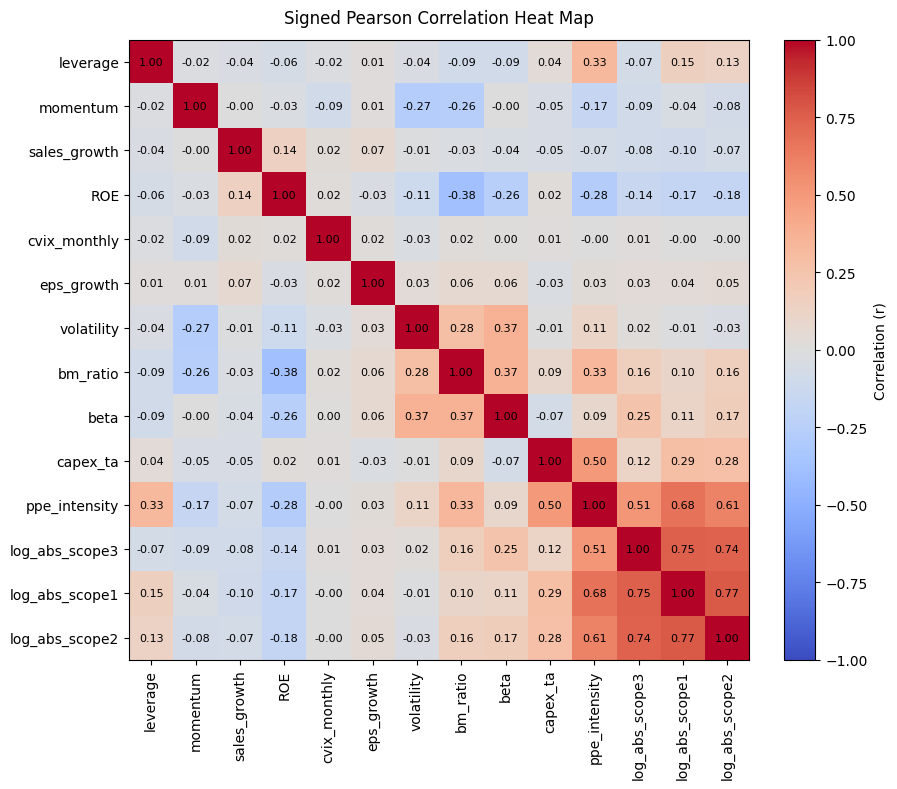

In [57]:
# Assume your DataFrame is named data and already has log_size, log_ppe
df4["ppe_intensity"] = df4["log_ppe"] - df4["log_size"]  # log(PPE/Size)


# ----------------------------
# Variable specification
# ----------------------------
controls = ["cvix_monthly", "momentum","bm_ratio","leverage",
            "capex_ta","sales_growth","eps_growth","ROE","volatility",
            "beta","ppe_intensity"]
emissions = ["log_abs_scope1","log_abs_scope2","log_abs_scope3"]
vars_of_interest = controls + emissions

# ----------------------------
# Build numeric subset
# ----------------------------
source_data = df4  # keep your original name; NOT using 'df'
present = [v for v in vars_of_interest if v in source_data.columns]
corr_data = source_data[present].apply(pd.to_numeric, errors="coerce")

# Optionally drop near-constant columns (<=1 unique non-missing value)
near_constant = [c for c in corr_data.columns if corr_data[c].nunique(dropna=True) <= 1]
if near_constant:
    print("Dropping near-constant columns (no variance):", near_constant)
    corr_data = corr_data.drop(columns=near_constant)

# ----------------------------
# Correlation Matrix
# ----------------------------
corr_matrix = corr_data.corr(method="pearson")

# ----------------------------
# (Optional) reorder variables by hierarchical clustering to group similar ones
# Comment out this block if you want original order retained.
# ----------------------------
try:
    from scipy.cluster.hierarchy import linkage, leaves_list
    z = linkage(corr_matrix.fillna(0), method='average')
    order = leaves_list(z)
    corr_matrix = corr_matrix.iloc[order, :].iloc[:, order]
except Exception:
    pass  # if scipy not available, just skip reordering

# ----------------------------
# Heat Map (Signed)
# ----------------------------
fig, ax = plt.subplots(figsize=(10, 8))

# Use a diverging colormap with strong contrast; 'coolwarm' or 'RdBu_r' are common.
cax = ax.imshow(corr_matrix, vmin=-1, vmax=1, cmap='coolwarm')

# Annotate each cell with correlation (skip NaNs)
for i in range(corr_matrix.shape[0]):
    for j in range(corr_matrix.shape[1]):
        val = corr_matrix.iloc[i, j]
        if not np.isnan(val):
            ax.text(j, i, f"{val:.2f}", ha='center', va='center', fontsize=8, color='black')

ax.set_xticks(range(corr_matrix.shape[1]))
ax.set_yticks(range(corr_matrix.shape[0]))
ax.set_xticklabels(corr_matrix.columns, rotation=90)
ax.set_yticklabels(corr_matrix.index)
ax.set_title("Signed Pearson Correlation Heat Map", pad=12)

cbar = plt.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Correlation (r)")

plt.tight_layout()
plt.show()

### VIFs

In [58]:
def vif_one_emission(data, emission_var, high_cut=5, impute=True):
    if emission_var not in emissions:
        raise ValueError(f"Choose emission_var from {emission_scopes}")
    cols = [c for c in controls + [emission_var] if c in data.columns]
    Xdf = data[cols].apply(pd.to_numeric, errors="coerce").replace([np.inf,-np.inf], np.nan)
    if impute:
        Xdf = Xdf.apply(lambda s: s.fillna(s.median()))
    else:
        Xdf = Xdf.dropna()
    X = Xdf.to_numpy(dtype=float)
    vif = [
        (col, variance_inflation_factor(X, i))
        for i, col in enumerate(Xdf.columns)
    ]
    res = pd.DataFrame(vif, columns=["variable","VIF"]).sort_values("VIF", ascending=False).reset_index(drop=True)
    print(res.to_string(index=False))
    hi = res[res.VIF > high_cut]
    if not hi.empty:
        print(f"\n> VIF > {high_cut}:")
        print(hi.to_string(index=False))
    return res

# Example:
vif_scope1 = vif_one_emission(df4, "log_abs_scope1")

      variable       VIF
  cvix_monthly 22.710007
log_abs_scope1 16.670569
          beta 11.428895
    volatility  9.266529
 ppe_intensity  4.321514
      capex_ta  4.172687
      leverage  3.687353
      bm_ratio  3.319286
           ROE  2.596281
      momentum  1.281623
  sales_growth  1.034346
    eps_growth  1.014111

> VIF > 5:
      variable       VIF
  cvix_monthly 22.710007
log_abs_scope1 16.670569
          beta 11.428895
    volatility  9.266529


In [59]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47088 entries, 13 to 48919
Data columns (total 59 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   parentname                           47088 non-null  object        
 1   companyname                          47088 non-null  string        
 2   ticker                               47088 non-null  string        
 3   gvkey                                47088 non-null  object        
 4   isin                                 47088 non-null  object        
 5   iid                                  47088 non-null  Float64       
 6   date                                 47088 non-null  datetime64[ns]
 7   sic_code                             47088 non-null  Int64         
 8   cls_prc                              47088 non-null  Float64       
 9   ret_1d                               47088 non-null  Float64       
 10  ret_5d        

# PanelOLS

## Regression

In [106]:
## Ensuring corect format
df4["sic_code"] = df4["sic_code"].astype(str)
df4["gvkey"]    = df4["gvkey"].astype(str)   # for clustering groups

## Option for excluding data from 2020
# df4 = df4[df4["date"].dt.year != 2020]  # <— drop all 2020 obs ### Comment out when not needed. 

# Create a year-month string for time fixed effects
df4["year_month"] = df4["date"].dt.to_period("M").astype(str)

# Drop missing data in any of the regression vars
vars_needed = [
    "ret_1m", "cvix_monthly",
    # emissions dummies
    "log_abs_scope1_top20", "log_abs_scope2_top20", "log_abs_scope3_top20",
    "int_scope1_top20", "int_scope2_top20", "int_scope3_top20",
    # dummy interaction
    "log_abs_scope1_top20_x_CVIX", "log_abs_scope2_top20_x_CVIX", "log_abs_scope3_top20_x_CVIX",
    "int_scope1_top20_x_CVIX",  "int_scope2_top20_x_CVIX",  "int_scope3_top20_x_CVIX", 
    #continous emissions
    "log_abs_scope1", "log_abs_scope2", "log_abs_scope3","int_scope1", "int_scope2", "int_scope3",
    # continous emissions interaction
    "log_abs_scope1_x_CVIX", "log_abs_scope2_x_CVIX", "log_abs_scope3_x_CVIX",
    "int_scope1_x_CVIX", "int_scope2_x_CVIX", "int_scope3_x_CVIX",
    #controls
    'momentum',
    "bm_ratio", "leverage", "capex_ta",
    "ppe_intensity", "sales_growth", "eps_growth", "ROE", "volatility", "beta",
    "sic_code", "year_month", "gvkey"
]
df4 = df4.dropna(subset=vars_needed)

# 2) Common controls & fixed effects
controls = "momentum + bm_ratio + leverage + capex_ta + ppe_intensity + sales_growth + eps_growth + ROE + volatility + beta"
industry_fe = "C(sic_code)"
time_fe= "C(year_month)"

# 3) Helper to run and print one OLS
def run_ols(depvar, dummy, interaction):
    formula = (
        f"{depvar} ~ {dummy} + {interaction} + {controls} + "
        f"{industry_fe} + {time_fe}"
    )
    model = smf.ols(formula, data=df4).fit(
        cov_type="cluster",
        cov_kwds={
            "groups": df4["gvkey"], # firm-cluster
            "other":  df4["year_month"]    # time‐cluster
        }
    )
    # print("\n\n", "#" * 60)
    # print(f"Model: {dummy}  &  {interaction}")
    # print(model.summary())
    return model

def run_ols_no_industry_effects(depvar, dummy, interaction):
    formula = (
        f"{depvar} ~ {dummy} + {interaction} + {controls} + "
        f"{time_fe}"
    )
    model = smf.ols(formula, data=df4).fit(
        cov_type="cluster",
        cov_kwds={
            "groups": df4["gvkey"], # firm-cluster
            "other":  df4["year_month"]    # time‐cluster
        }
    )
    # print("\n\n", "#" * 60)
    # print(f"Model: {dummy}  &  {interaction}")
    # print(model.summary())
    return model

### containers to store results
models_abs_with_ind = []
models_abs_no_ind   = []
models_int_with_ind = []
models_int_no_ind   = []

# Panel A) Absolute emissions dummies
abs_dummies = ["log_abs_scope1_top20","log_abs_scope2_top20","log_abs_scope3_top20"]
for d in abs_dummies:
    m_no   = run_ols_no_industry_effects("ret_1m", d, f"{d}_x_CVIX")
    m_with = run_ols("ret_1m", d, f"{d}_x_CVIX")
    models_abs_with_ind.append( (m_with, d) )
    models_abs_no_ind.append(   (m_no,   d) )

# Panel B) Intensity emissions dummies
int_dummies = ["int_scope1_top20","int_scope2_top20","int_scope3_top20"]
for d in int_dummies:
    m_no   = run_ols_no_industry_effects("ret_1m", d, f"{d}_x_CVIX")
    m_with = run_ols("ret_1m", d, f"{d}_x_CVIX")
    models_int_with_ind.append( (m_with, d) )
    models_int_no_ind.append(   (m_no,   d) )

### Continous Regression

In [107]:
# New containers for Panels C & D
models_abs_cont_with_ind = []
models_abs_cont_no_ind   = []
models_int_cont_with_ind = []
models_int_cont_no_ind   = []

# Panel C) Absolute emissions (continuous)
abs_continuous = ["log_abs_scope1","log_abs_scope2","log_abs_scope3"]
for v in abs_continuous:
    m_no   = run_ols_no_industry_effects("ret_1m", v, f"{v}_x_CVIX")
    m_with = run_ols("ret_1m", v, f"{v}_x_CVIX")
    models_abs_cont_with_ind.append( (m_with, v) )
    models_abs_cont_no_ind.append(   (m_no,   v) )

# Panel D) Intensity emissions (continuous)
int_continuous = ["int_scope1","int_scope2","int_scope3"]
for v in int_continuous:
    m_no   = run_ols_no_industry_effects("ret_1m", v, f"{v}_x_CVIX")
    m_with = run_ols("ret_1m", v, f"{v}_x_CVIX")
    models_int_cont_with_ind.append( (m_with, v) )
    models_int_cont_no_ind.append(   (m_no,   v) )

### Dummy Regression without 2020 & 2021

In [108]:
### —————————————————————————————————————————————————————————
### Panel E & F: Continuous emissions (drop 2020 & 2021 obs)
### —————————————————————————————————————————————————————————

# 1) create a subset without 2020 and 2021
df_subset = df4[~df4["date"].dt.year.isin([2020, 2021])].copy()
df_subset = df_subset.dropna(subset=vars_needed)

# 2) temporarily override df4 so run_ols uses our subset
_df4_backup = df4
df4 = df_subset

# 3) containers for E & F
models_cont_abs_with_ind = []
models_cont_abs_no_ind   = []
models_cont_int_with_ind = []
models_cont_int_no_ind   = []

# Panel E) Continuous absolute emissions
abs_dummies = ["log_abs_scope1_top20","log_abs_scope2_top20","log_abs_scope3_top20"]
for d in abs_dummies:
    m_wo = run_ols_no_industry_effects("ret_1m", d, f"{d}_x_CVIX")
    m_w = run_ols("ret_1m", d, f"{d}_x_CVIX")
    models_cont_abs_with_ind.append((m_w, d))
    models_cont_abs_no_ind.append((m_wo, d))

# Panel F) Continuous intensity emissions
int_dummies = ["int_scope1_top20","int_scope2_top20","int_scope3_top20"]
for d in int_dummies:
    m_wo = run_ols_no_industry_effects("ret_1m", d, f"{d}_x_CVIX")
    m_w = run_ols("ret_1m", d, f"{d}_x_CVIX")
    models_cont_int_with_ind.append((m_w, d))
    models_cont_int_no_ind.append((m_wo, d))

# 4) restore original df4
df4 = _df4_backup
del _df4_backup

### Relabelling, significance identification, remapping

In [109]:
# ================== Helpers & Configuration ================== #

controls_list = [c.strip() for c in controls.split('+')]

def signif_stars(p: float) -> str:
    if p < 0.01: return "***"
    if p < 0.05: return "**"
    if p < 0.10: return "*"
    return ""

def clean_row_label(var: str) -> str:
    if var == "INTERCEPT":
        return "Intercept"
    if var.endswith("_top20"):
        if var.startswith("log_abs_scope"):
            sc = var.split("log_abs_scope")[1].split("_")[0]
            return f"Scope {sc} (Abs)"
        if var.startswith("int_scope"):
            sc = var.split("int_scope")[1].split("_")[0]
            return f"Scope {sc} (Intensity)"
    if var.endswith("_x_CVIX"):
        if "log_abs_scope" in var:
            sc = var.split("log_abs_scope")[1].split("_")[0]
            return f"Scope {sc} × CVIX (Abs)"
        if "int_scope" in var:
            sc = var.split("int_scope")[1].split("_")[0]
            return f"Scope {sc} × CVIX (Intensity)"

    # Continuous (new)
    if var.startswith("log_abs_scope") and "_x_CVIX" not in var:
        sc = var.split("log_abs_scope")[1]
        return f"Scope {sc} (Abs, log)"
    if var.startswith("int_scope") and "_x_CVIX" not in var and "_top20" not in var:
        sc = var.split("int_scope")[1]
        return f"Scope {sc} (Intensity)"
    if var.startswith("log_abs_scope") and var.endswith("_x_CVIX") and "_top20" not in var:
        sc = var.split("log_abs_scope")[1].split("_")[0]
        return f"Scope {sc} × CVIX (Abs, log)"
    if var.startswith("int_scope") and var.endswith("_x_CVIX") and "_top20" not in var:
        sc = var.split("int_scope")[1].split("_")[0]
        return f"Scope {sc} × CVIX (Intensity)"
        
    mapping = {
        "carbon_price": "Carbon price",
        "momentum":     "Momentum",
        "log_size":     "Size (log)",
        "bm_ratio":     "Book-to-Market",
        "leverage":     "Leverage",
        "capex_ta":     "CapEx / TA",
        "log_ppe":      "PPE (log)",
        "sales_growth": "Sales growth",
        "eps_growth":   "EPS growth",
        "beta":         "Market Beta",
        "ROE":          "Return on Equity",
        "volatility":   "Volatility (1Y)"
    }
    return mapping.get(var, var)





### Building panel for final display using Regression data

In [110]:
# ================== Panel Construction ================== #

def build_panel(models_with_ind, models_no_ind, abs_or_int: str,
                main_label_suffix="Scope Dummy",
                inter_label_suffix="Scope Dummy x CVIX") -> pd.DataFrame:
    """
    Combine 6 models (3 with industry FE + time FE, 3 with time FE only)
    into a raw panel (cells 'coef\\n(se)') including controls, interactions,
    and stats. Adds intercept explicitly.
    """
    # 1) permanently reverse the order: No‐FE models first
    all_models = models_no_ind + models_with_ind
    half       = len(models_no_ind)

    # 2) build labels by position, not membership
    col_labels = []
    for i, (m, scope_var) in enumerate(all_models):
        scope_num = scope_var.split("scope")[1].split("_")[0]
        fe_tag    = "No Ind FE" if i < half else "Ind FE"
        col_labels.append(f"Scope {scope_num} ({fe_tag})")

    # ———————————————————————————————————————
    # rest of your code is **unchanged**:
    base_rows    = ["INTERCEPT", "SCOPE_DUMMY", "SCOPE_X_CVIX"] + controls_list
    rows_display = OrderedDict((row_id, []) for row_id in base_rows)

    for (m, scope_var) in all_models:
        interaction    = f"{scope_var}_x_CVIX"
        intercept_name = "Intercept" if "Intercept" in m.params.index else "const"
        for row_id in base_rows:
            if row_id == "INTERCEPT":
                varname = intercept_name
            elif row_id == "SCOPE_DUMMY":
                varname = scope_var
            elif row_id == "SCOPE_X_CVIX":
                varname = interaction
            else:
                varname = row_id

            if varname in m.params.index:
                coef = m.params[varname]
                se   = m.bse[varname]
                p    = m.pvalues[varname]
                rows_display[row_id].append(f"{coef: .4f}{signif_stars(p)}\n({se: .4f})")
            else:
                rows_display[row_id].append("")

    df_panel = pd.DataFrame(rows_display, index=col_labels).T

    renamed_index = []
    for rid in df_panel.index:
        if rid == "SCOPE_DUMMY":
            renamed_index.append(f"{abs_or_int} Scope Dummy")
        elif rid == "SCOPE_X_CVIX":
            renamed_index.append(f"{abs_or_int} Scope Dummy × CVIX")
        else:
            renamed_index.append(clean_row_label(rid))
    df_panel.index = renamed_index

    r2, adj_r2, nobs = [], [], []
    for (m, _) in all_models:
        r2.append(f"{m.rsquared: .3f}")
        adj_r2.append(f"{m.rsquared_adj: .3f}")
        nobs.append(f"{int(m.nobs)}")

    stats_df = pd.DataFrame({
        "R-squared":      r2,
        "Adj. R-squared": adj_r2,
        "Observations":   nobs
    }, index=col_labels).T
    df_panel = pd.concat([df_panel, stats_df])

    sample_start = df4["date"].min().strftime("%Y-%m")
    sample_end   = df4["date"].max().strftime("%Y-%m")
    sample_label = f"Sample: {sample_start}–{sample_end}"
    sample_row   = pd.DataFrame([[sample_label] + [""]*(len(col_labels)-1)],
                                index=["Sample period"], columns=col_labels)
    df_panel = pd.concat([df_panel, sample_row])

    return df_panel

### Final Setup and display preferences

In [111]:
# ================== FE Indicator & Ordering Helpers ================== #

def add_fe_indicator_rows(df):
    df = df.copy()
    k    = len(df.columns)
    half = k // 2

    # first half = No Ind FE, second half = Ind FE
    if "Industry FE" not in df.index:
        df.loc["Industry FE"] = ["No"]*half + ["Yes"]*(k-half)
    if "Time FE" not in df.index:
        df.loc["Time FE"] = ["Yes"]*k

    return df

def reorder_before_expand(df):
    tail = ["R-squared","Adj. R-squared","Observations","Sample period",
            "Industry FE","Time FE"]
    body = [r for r in df.index if r not in tail]
    return df.loc[body + [r for r in tail if r in df.index]]

# ================== Coef / SE Expansion ================== #

def expand_coef_se_rows(df_raw: pd.DataFrame) -> pd.DataFrame:
    stat_like = {"R-squared","Adj. R-squared","Observations","Sample period",
                 "Industry FE","Time FE"}
    new_rows, new_index = [], []
    for idx, row in df_raw.iterrows():
        if idx in stat_like:
            new_rows.append(row)
            new_index.append(idx)
            continue
        coef_row = row.apply(
            lambda x: x.split("\n")[0] if isinstance(x,str) and "\n" in x else x
        )
        se_row = row.apply(
            lambda x: x.split("\n")[1] if isinstance(x,str) and "\n" in x else ""
        )
        new_rows.append(coef_row); new_index.append(idx)
        new_rows.append(se_row);   new_index.append("")  # blank SE line label
    return pd.DataFrame(new_rows, index=new_index, columns=df_raw.columns)

# ================== Build Absolute & Intensity Dummy Panels ================== #

panelA_raw = build_panel(models_abs_with_ind, models_abs_no_ind, "Absolute")
panelB_raw = build_panel(models_int_with_ind, models_int_no_ind, "Intensity")

panelA_raw = add_fe_indicator_rows(panelA_raw)
panelB_raw = add_fe_indicator_rows(panelB_raw)

panelA_raw = reorder_before_expand(panelA_raw)
panelB_raw = reorder_before_expand(panelB_raw)

panelA_expanded = expand_coef_se_rows(panelA_raw)
panelB_expanded = expand_coef_se_rows(panelB_raw)

simple_headers = ["Scope 1","Scope 2","Scope 3","Scope 1","Scope 2","Scope 3"]
panelA_expanded.columns = simple_headers
panelB_expanded.columns = simple_headers

panelA = panelA_expanded
panelB = panelB_expanded

# ================== Build Continous Absolute & Intensity Panels ================== #

panelC_raw = build_panel(models_abs_cont_with_ind, models_abs_cont_no_ind,
                         "Absolute", main_label_suffix="(log) Scope", inter_label_suffix="(log) Scope × CVIX")
panelD_raw = build_panel(models_int_cont_with_ind, models_int_cont_no_ind,
                         "Intensity", main_label_suffix="Scope Intensity", inter_label_suffix="Scope Intensity × CVIX")

panelC_raw = add_fe_indicator_rows(panelC_raw)
panelD_raw = add_fe_indicator_rows(panelD_raw)

panelC_raw = reorder_before_expand(panelC_raw)
panelD_raw = reorder_before_expand(panelD_raw)

panelC_expanded = expand_coef_se_rows(panelC_raw)
panelD_expanded = expand_coef_se_rows(panelD_raw)

panelC_expanded.columns = simple_headers  # same 6 columns order expected
panelD_expanded.columns = simple_headers

panelC = panelC_expanded
panelD = panelD_expanded

# ================== Build Subsample Panels E & F (exclude 2020 & 2021) ================== #

panelE_raw = build_panel(
    models_cont_abs_with_ind, models_cont_abs_no_ind,
    "Absolute",
    main_label_suffix="(log) Scope",
    inter_label_suffix="(log) Scope × CVIX"
)
panelF_raw = build_panel(
    models_cont_int_with_ind, models_cont_int_no_ind,
    "Intensity",
    main_label_suffix="Scope Intensity",
    inter_label_suffix="Scope Intensity × CVIX"
)

panelE_raw = add_fe_indicator_rows(panelE_raw)
panelF_raw = add_fe_indicator_rows(panelF_raw)

panelE_raw = reorder_before_expand(panelE_raw)
panelF_raw = reorder_before_expand(panelF_raw)

panelE_expanded = expand_coef_se_rows(panelE_raw)
panelF_expanded = expand_coef_se_rows(panelF_raw)

panelE_expanded.columns = simple_headers
panelF_expanded.columns = simple_headers

panelE = panelE_expanded
panelF = panelF_expanded

### Plotting

In [112]:
import matplotlib.pyplot as plt
import numpy as np

# ── 1. Global font config for readability ────────────────────────────────────
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
})

def plot_marginal_effect_subplot(model_results, chart_title, axis):
    """
    Draws one subplot showing marginal effect lines + 95% CI bands.

    Parameters:
    - model_results: list of (fitted_model, variable_name) tuples
    - chart_title:   title string for this subplot
    - axis:          matplotlib Axes on which to plot
    """
    # Generate a smooth range of CVIX values
    cvix_min = df4['cvix_monthly'].min()
    cvix_max = df4['cvix_monthly'].max()
    cvix_grid = np.linspace(cvix_min, cvix_max, 100)
    
    for fitted_model, var_name in model_results:
        # Coefficients
        beta_main = fitted_model.params[var_name]
        beta_inter = fitted_model.params[f"{var_name}_x_CVIX"]
        # Covariance matrix slice
        cov_slice = fitted_model.cov_params().loc[
            [var_name, f"{var_name}_x_CVIX"],
            [var_name, f"{var_name}_x_CVIX"]
        ]
        # Marginal effect and its SE
        margin = beta_main + beta_inter * cvix_grid
        se = np.sqrt(
            cov_slice.loc[var_name, var_name]
            + (cvix_grid**2) * cov_slice.loc[f"{var_name}_x_CVIX", f"{var_name}_x_CVIX"]
            + 2 * cvix_grid * cov_slice.loc[var_name, f"{var_name}_x_CVIX"]
        )
        lower = margin - 1.96 * se
        upper = margin + 1.96 * se

        # Label by scope number (1/2/3)
        scope_num = var_name.split("scope")[1].split("_")[0]
        label = f"Scope {scope_num}"
        
        # Plot line + full CI shading
        line = axis.plot(cvix_grid, margin, linewidth=2, label=label)[0]
        axis.fill_between(cvix_grid, lower, upper, color=line.get_color(), alpha=0.25)

        # remove the 1e-5 offset and force plain decimal ticks
        axis.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
        axis.ticklabel_format(style='plain', axis='y')

    # Zero reference, grid, labels
    axis.axhline(0, color='black', linestyle='--', linewidth=1)
    axis.grid(axis='y', linestyle=':', alpha=0.6)
    axis.set_title(chart_title, pad=14)
    axis.set_xlabel("CVIX")
    axis.set_ylabel("Marginal Effect on Return")
    axis.tick_params(labelsize=11)

def plot_panel_marginal_effects(
    with_ind_fe_models,
    without_ind_fe_models,
    panel_label,
    variable_description
):
    """
    Creates a 1×2 figure: left=without industry FE, right=with industry FE.

    Parameters:
    - with_ind_fe_models:    list of (model, var_name) with industry FE
    - without_ind_fe_models: list of (model, var_name) without industry FE
    - panel_label:           string, e.g. "A", "B", etc.
    - variable_description:  description for title, e.g. "Absolute Dummy × CVIX"
    """
    fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

    plot_marginal_effect_subplot(
        without_ind_fe_models,
        f"Panel {panel_label}: {variable_description}\n(No Industry FE)",
        ax_left
    )
    plot_marginal_effect_subplot(
        with_ind_fe_models,
        f"Panel {panel_label}: {variable_description}\n(Industry FE included)",
        ax_right
    )

    # Legend on the right-hand plot
    ax_right.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=11)
    plt.tight_layout()
    plt.show()

# Results

## Results for regression using dummy variables

=== Table: Panel A ===


,Scope 1,Scope 2,Scope 3,Scope 1,Scope 2,Scope 3
Intercept,0.0252***,0.0265***,0.0266***,0.0420***,0.0429***,0.0440***
,( 0.0046),( 0.0046),( 0.0046),( 0.0064),( 0.0065),( 0.0066)
Absolute Scope Dummy,-0.0091**,-0.0155***,-0.0162***,-0.0110**,-0.0169***,-0.0189***
,( 0.0042),( 0.0042),( 0.0041),( 0.0045),( 0.0043),( 0.0043)
Absolute Scope Dummy × CVIX,0.0003***,0.0003***,0.0003***,0.0003***,0.0003***,0.0003***
,( 0.0001),( 0.0001),( 0.0001),( 0.0001),( 0.0001),( 0.0001)
Momentum,-0.0030,-0.0025,-0.0025,-0.0106***,-0.0105***,-0.0106***
,( 0.0019),( 0.0018),( 0.0018),( 0.0022),( 0.0022),( 0.0022)
Book-to-Market,-0.0144***,-0.0142***,-0.0139***,-0.0176***,-0.0174***,-0.0173***
,( 0.0019),( 0.0019),( 0.0019),( 0.0023),( 0.0024),( 0.0024)


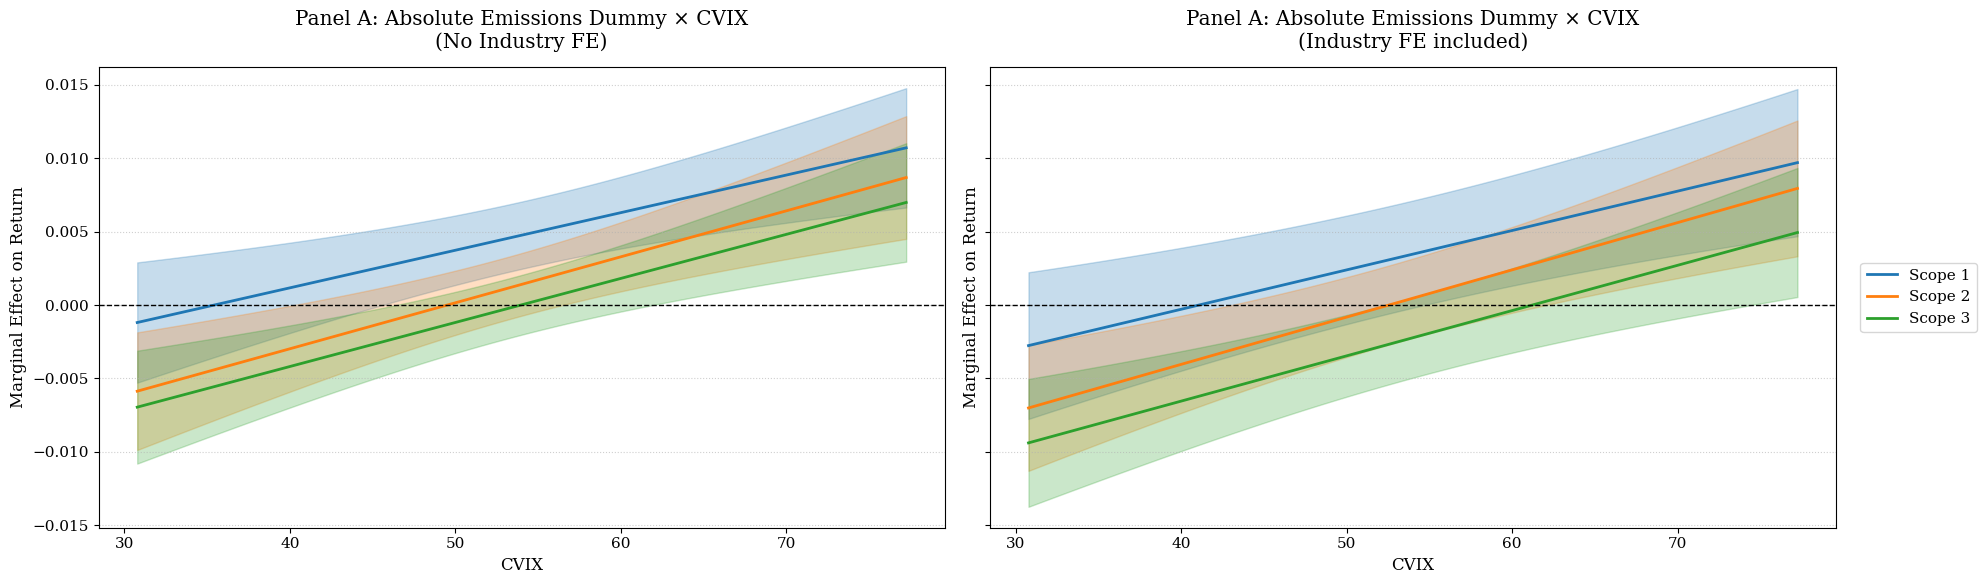

=== Table: Panel B ===


,Scope 1,Scope 2,Scope 3,Scope 1,Scope 2,Scope 3
Intercept,0.0253***,0.0267***,0.0269***,0.0400***,0.0414***,0.0435***
,( 0.0046),( 0.0045),( 0.0045),( 0.0067),( 0.0065),( 0.0065)
Intensity Scope Dummy,-0.0123**,-0.0107*,-0.0109**,-0.0149***,-0.0112*,-0.0108**
,( 0.0051),( 0.0055),( 0.0044),( 0.0054),( 0.0058),( 0.0048)
Intensity Scope Dummy × CVIX,0.0003***,0.0003**,0.0002***,0.0003***,0.0003***,0.0002**
,( 0.0001),( 0.0001),( 0.0001),( 0.0001),( 0.0001),( 0.0001)
Momentum,-0.0034*,-0.0026,-0.0024,-0.0106***,-0.0104***,-0.0104***
,( 0.0019),( 0.0018),( 0.0018),( 0.0022),( 0.0022),( 0.0022)
Book-to-Market,-0.0144***,-0.0137***,-0.0139***,-0.0175***,-0.0173***,-0.0173***
,( 0.0022),( 0.0019),( 0.0019),( 0.0024),( 0.0024),( 0.0024)


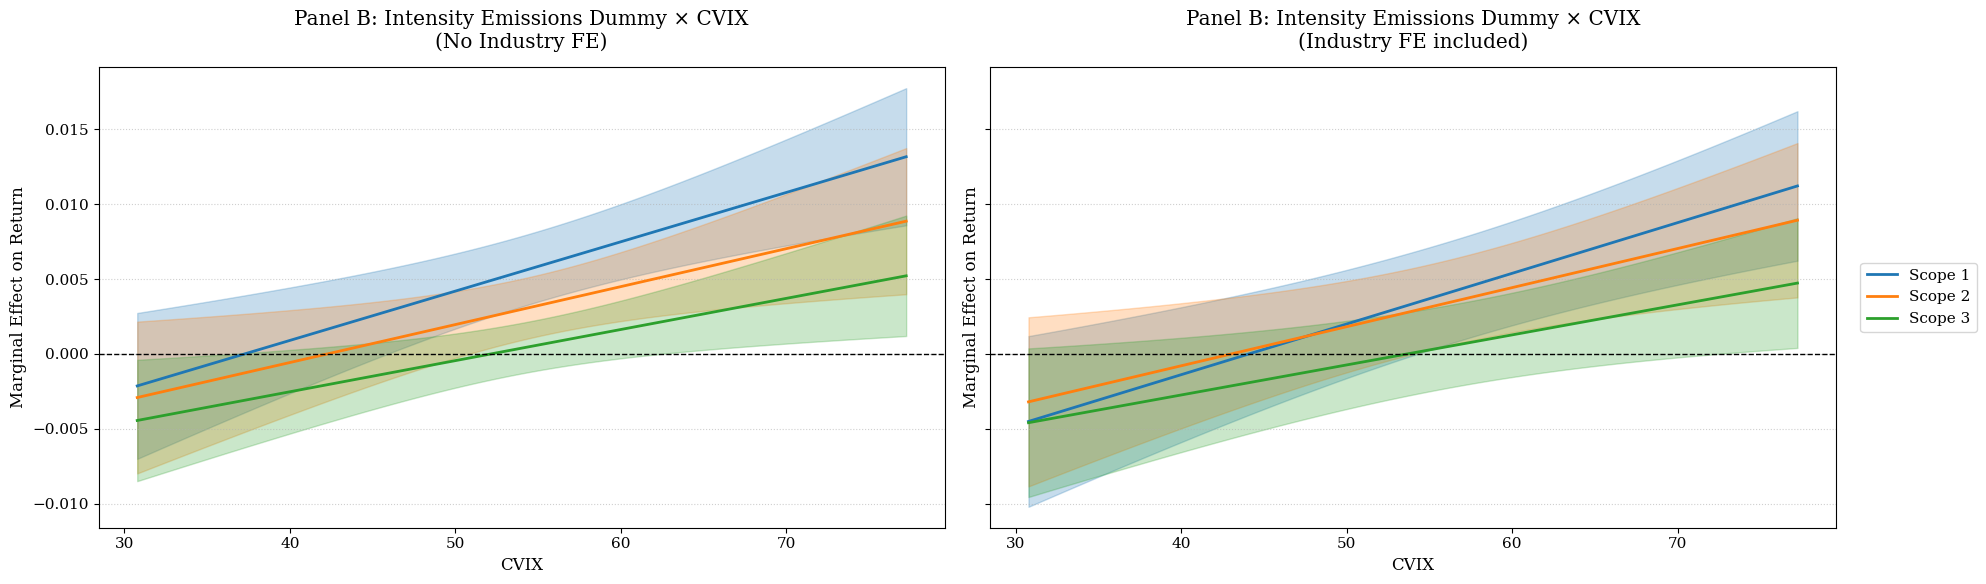

In [113]:
# ─── Panel A ───
print("=== Table: Panel A ===")
display(panelA)

plot_panel_marginal_effects(
    with_ind_fe_models=models_abs_with_ind,
    without_ind_fe_models=models_abs_no_ind,
    panel_label="A",
    variable_description="Absolute Emissions Dummy × CVIX"
)

# ─── Panel B ───
print("=== Table: Panel B ===")
display(panelB)

plot_panel_marginal_effects(
    with_ind_fe_models=models_int_with_ind,
    without_ind_fe_models=models_int_no_ind,
    panel_label="B",
    variable_description="Intensity Emissions Dummy × CVIX"
)

## Results for regression using continous variables

=== Table: Panel C ===


,Scope 1,Scope 2,Scope 3,Scope 1,Scope 2,Scope 3
Intercept,0.0028,0.0090,0.0017,0.0226***,0.0218**,0.0157
,( 0.0063),( 0.0080),( 0.0079),( 0.0084),( 0.0101),( 0.0098)
Absolute Scope Dummy,-0.0029***,-0.0049***,-0.0050***,-0.0033***,-0.0048***,-0.0049***
,( 0.0007),( 0.0009),( 0.0010),( 0.0007),( 0.0010),( 0.0011)
Absolute Scope Dummy × CVIX,0.0001***,0.0001***,0.0001***,0.0001***,0.0001***,0.0001***
,( 0.0000),( 0.0000),( 0.0000),( 0.0000),( 0.0000),( 0.0000)
Momentum,-0.0029,-0.0026,-0.0025,-0.0107***,-0.0105***,-0.0105***
,( 0.0019),( 0.0018),( 0.0019),( 0.0022),( 0.0022),( 0.0022)
Book-to-Market,-0.0144***,-0.0139***,-0.0140***,-0.0175***,-0.0173***,-0.0174***
,( 0.0020),( 0.0019),( 0.0019),( 0.0024),( 0.0023),( 0.0024)


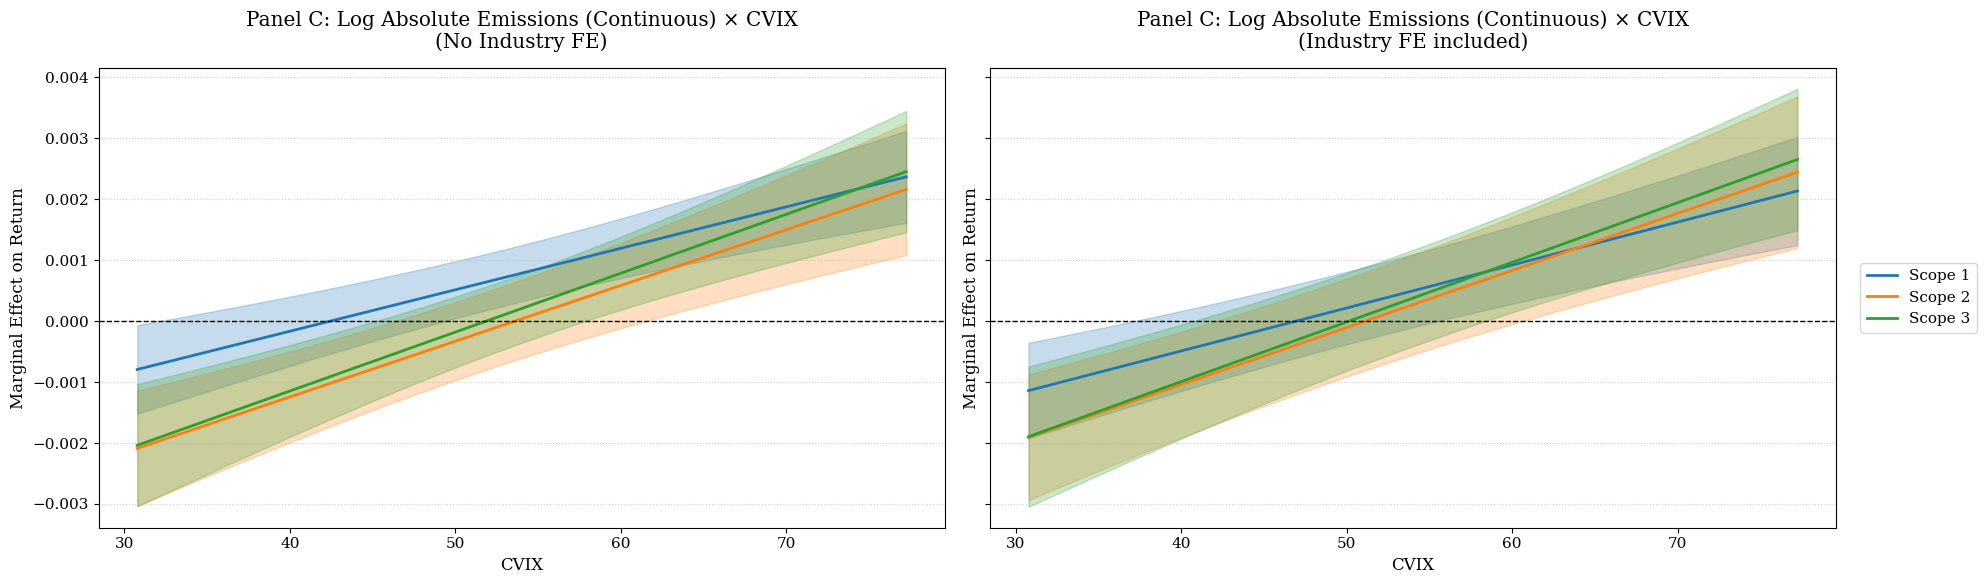

=== Table: Panel D ===


,Scope 1,Scope 2,Scope 3,Scope 1,Scope 2,Scope 3
Intercept,0.0267***,0.0274***,0.0270***,0.0438***,0.0438***,0.0434***
,( 0.0045),( 0.0045),( 0.0045),( 0.0065),( 0.0065),( 0.0063)
Intensity Scope Dummy,-0.0000***,-0.0000***,-0.0000*,-0.0000***,-0.0000***,-0.0000*
,( 0.0000),( 0.0000),( 0.0000),( 0.0000),( 0.0000),( 0.0000)
Intensity Scope Dummy × CVIX,0.0000***,0.0000***,0.0000**,0.0000***,0.0000***,0.0000**
,( 0.0000),( 0.0000),( 0.0000),( 0.0000),( 0.0000),( 0.0000)
Momentum,-0.0028,-0.0025,-0.0025,-0.0105***,-0.0105***,-0.0106***
,( 0.0019),( 0.0018),( 0.0018),( 0.0022),( 0.0022),( 0.0022)
Book-to-Market,-0.0141***,-0.0139***,-0.0140***,-0.0173***,-0.0173***,-0.0176***
,( 0.0020),( 0.0019),( 0.0019),( 0.0024),( 0.0024),( 0.0024)


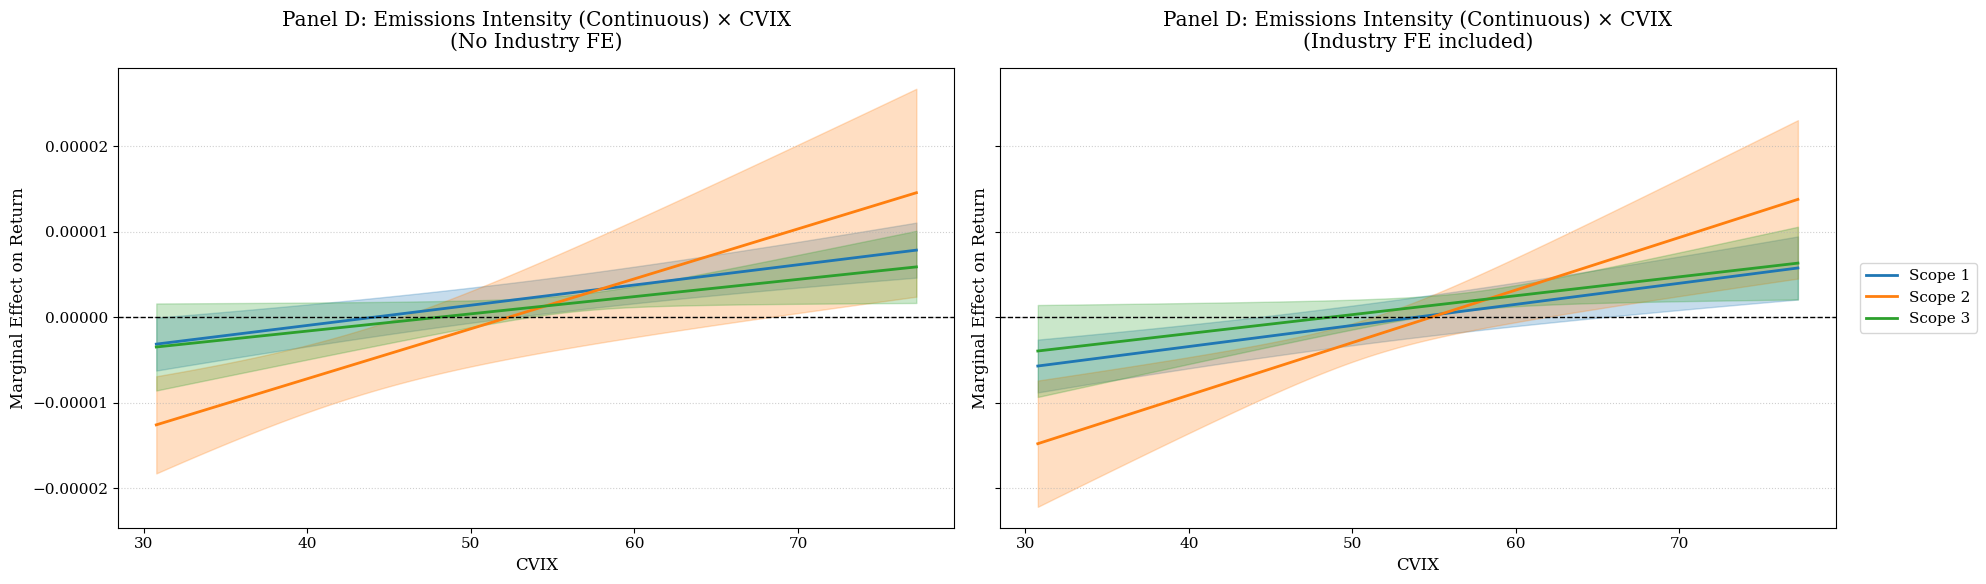

In [114]:
# ─── Panel C ───
from IPython.display import display

print("=== Table: Panel C ===")
display(panelC)

plot_panel_marginal_effects(
    with_ind_fe_models=models_abs_cont_with_ind,
    without_ind_fe_models=models_abs_cont_no_ind,
    panel_label="C",
    variable_description="Log Absolute Emissions (Continuous) × CVIX"
)

# ─── Panel D ───
from IPython.display import display

print("=== Table: Panel D ===")
display(panelD)

plot_panel_marginal_effects(
    with_ind_fe_models=models_int_cont_with_ind,
    without_ind_fe_models=models_int_cont_no_ind,
    panel_label="D",
    variable_description="Emissions Intensity (Continuous) × CVIX"
)


## Results for dummy without 2020 & 2021

=== Table: Panel E ===


,Scope 1,Scope 2,Scope 3,Scope 1,Scope 2,Scope 3
Intercept,0.0243***,0.0253***,0.0253***,0.0414***,0.0420***,0.0432***
,( 0.0046),( 0.0046),( 0.0046),( 0.0066),( 0.0067),( 0.0069)
Absolute Scope Dummy,-0.0099**,-0.0187***,-0.0186***,-0.0116**,-0.0201***,-0.0220***
,( 0.0044),( 0.0044),( 0.0043),( 0.0046),( 0.0044),( 0.0044)
Absolute Scope Dummy × CVIX,0.0003***,0.0004***,0.0003***,0.0003***,0.0004***,0.0004***
,( 0.0001),( 0.0001),( 0.0001),( 0.0001),( 0.0001),( 0.0001)
Momentum,-0.0022,-0.0017,-0.0017,-0.0098***,-0.0097***,-0.0099***
,( 0.0020),( 0.0020),( 0.0020),( 0.0024),( 0.0024),( 0.0024)
Book-to-Market,-0.0133***,-0.0129***,-0.0127***,-0.0162***,-0.0160***,-0.0160***
,( 0.0020),( 0.0020),( 0.0020),( 0.0024),( 0.0024),( 0.0024)


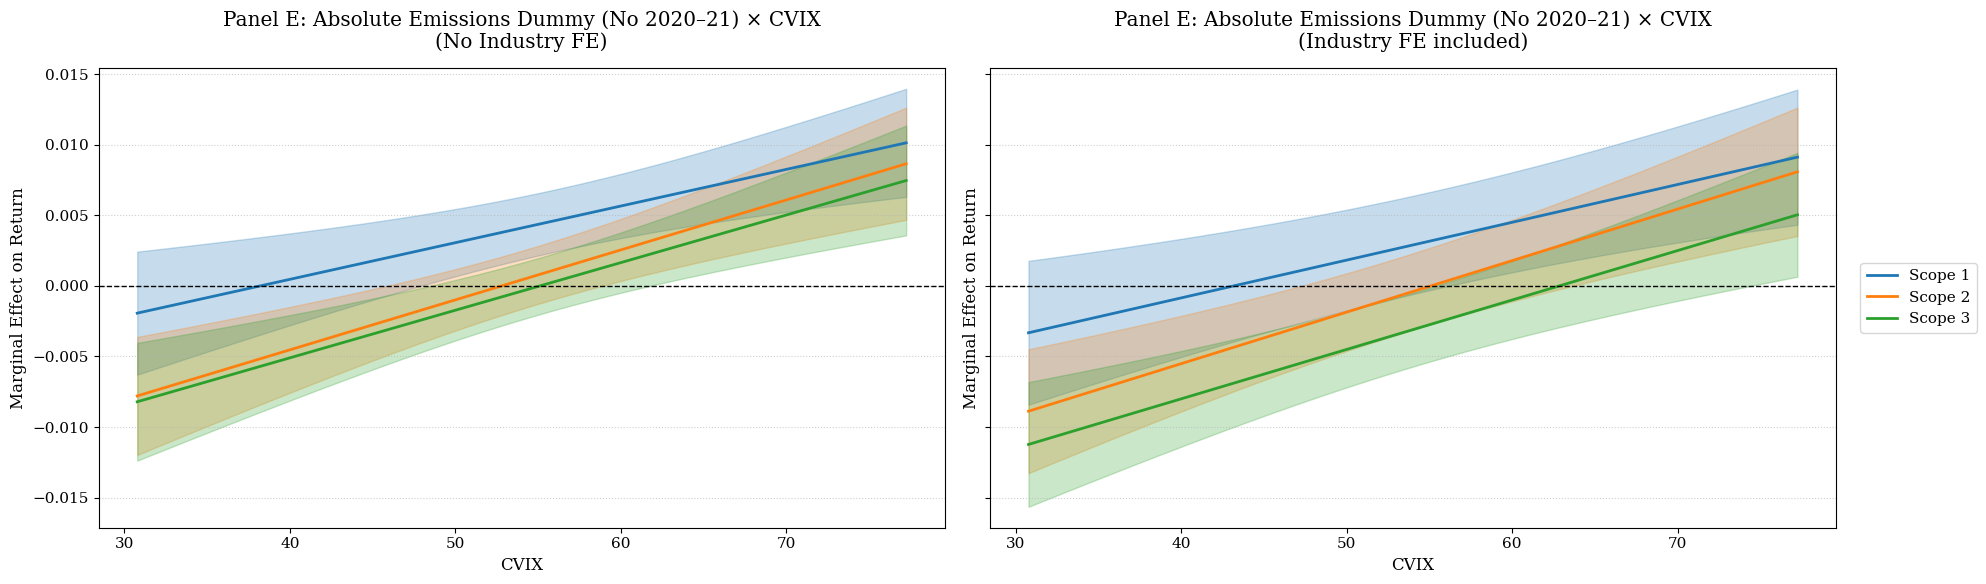

=== Table: Panel F ===


,Scope 1,Scope 2,Scope 3,Scope 1,Scope 2,Scope 3
Intercept,0.0245***,0.0258***,0.0258***,0.0409***,0.0407***,0.0428***
,( 0.0046),( 0.0045),( 0.0045),( 0.0069),( 0.0068),( 0.0067)
Intensity Scope Dummy,-0.0140***,-0.0123**,-0.0083*,-0.0173***,-0.0112*,-0.0081
,( 0.0050),( 0.0054),( 0.0047),( 0.0052),( 0.0057),( 0.0052)
Intensity Scope Dummy × CVIX,0.0003***,0.0003***,0.0002*,0.0003***,0.0003**,0.0002*
,( 0.0001),( 0.0001),( 0.0001),( 0.0001),( 0.0001),( 0.0001)
Momentum,-0.0025,-0.0016,-0.0015,-0.0098***,-0.0096***,-0.0095***
,( 0.0021),( 0.0020),( 0.0020),( 0.0024),( 0.0024),( 0.0024)
Book-to-Market,-0.0132***,-0.0126***,-0.0126***,-0.0160***,-0.0160***,-0.0159***
,( 0.0023),( 0.0020),( 0.0020),( 0.0024),( 0.0024),( 0.0024)


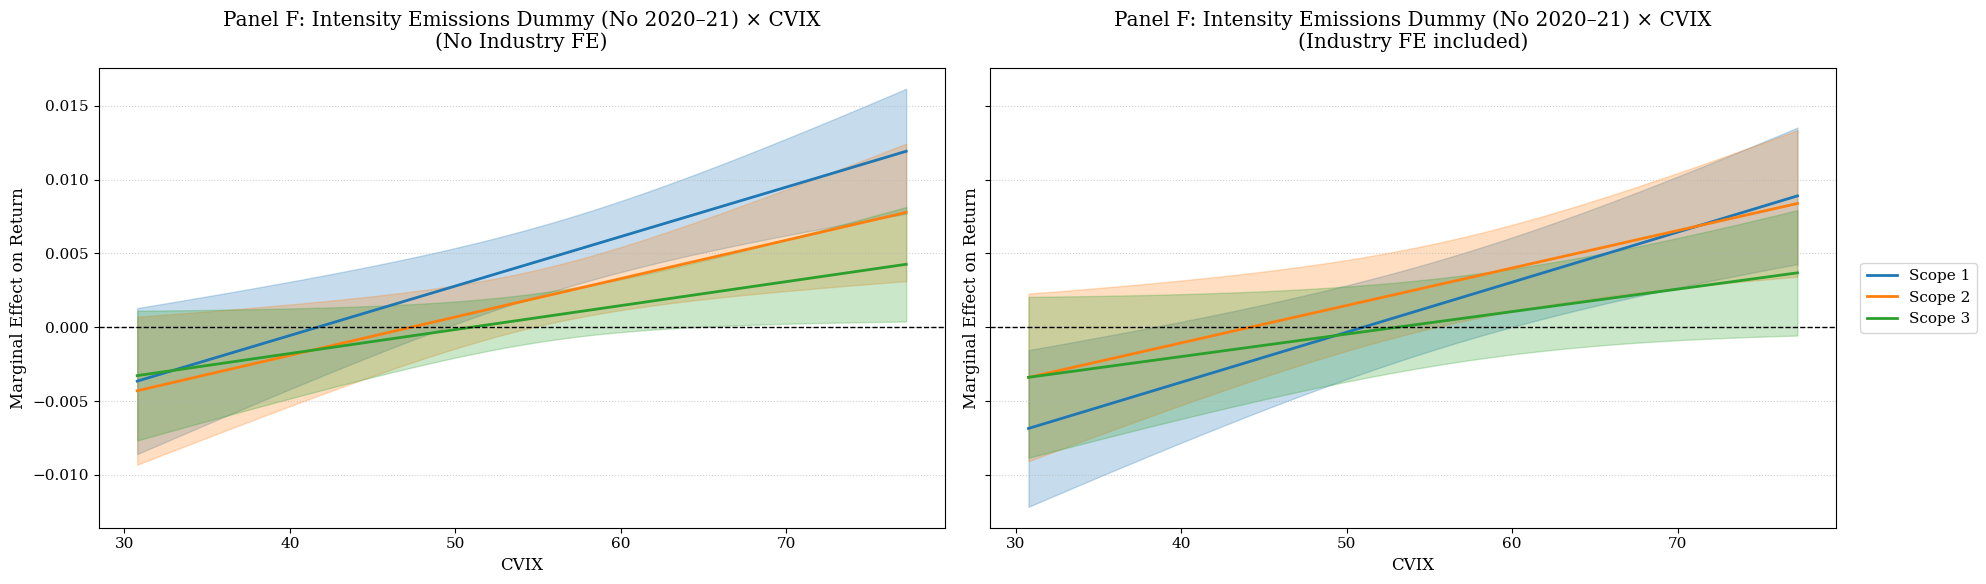

In [115]:
# ─── Panel E ───
print("=== Table: Panel E ===")
display(panelE)

plot_panel_marginal_effects(
    with_ind_fe_models=models_cont_abs_with_ind,
    without_ind_fe_models=models_cont_abs_no_ind,
    panel_label="E",
    variable_description="Absolute Emissions Dummy (No 2020–21) × CVIX"
)

# ─── Panel F ───
print("=== Table: Panel F ===")
display(panelF)

plot_panel_marginal_effects(
    with_ind_fe_models=models_cont_int_with_ind,
    without_ind_fe_models=models_cont_int_no_ind,
    panel_label="F",
    variable_description="Intensity Emissions Dummy (No 2020–21) × CVIX"
)

# Results Export

In [ ]:
# with pd.ExcelWriter("Thesis_Final_Results_2807.xlsx") as xw:
#     panelA.to_excel(xw, sheet_name="PanelA")
#     panelB.to_excel(xw, sheet_name="PanelB")
#     panelC.to_excel(xw, sheet_name="PanelC")
#     panelD.to_excel(xw, sheet_name="PanelD")    
#     panelE.to_excel(xw, sheet_name="PanelE")
#     panelF.to_excel(xw, sheet_name="PanelF")    